## Import

In [1]:
%load_ext autoreload
%autoreload 2

### TensorFlow and tf.keras

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models

2024-03-22 16:06:48.377032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 16:06:48.377070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 16:06:48.377984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 16:06:48.383655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 16:06:50.251161: W tensorflow/compiler/tf2

In [3]:
import sys
sys.path.insert(0, '../')

### Helper libraries

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, multilabel_confusion_matrix
from sklearn.datasets import make_multilabel_classification
from scipy.optimize import minimize

In [6]:
from sklearn.decomposition import PCA, NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [7]:
from tools.ramanflow.read_data import ReadData as rd
from tools.ramanflow.prep_data import PrepData as rpd

### Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
Tesla T4


## Data

In [8]:
f_sup, _ = rd.read_data("../data/20220422 SERS data generation/analyte 1/mapping50X50/1_3min_b3_50X50_spectral_mapping_1.tif")

In [9]:
_, colloids = rd.read_data("../data/20220422 SERS data generation/colloidal/mapping10X10/colloidal_3min_b3_10X10_500ms_spectral_mapping.tif")

In [9]:
spectra_dataset = rd.read_data("dataset.npy")

# Preprocessing

## PCA constant component analysis dot product

In [ ]:
def dot_product_along_axis(row):
    return np.dot(row, colloids[0])

In [ ]:
# Apply the custom function along axis 1
result = np.apply_along_axis(dot_product_along_axis, axis=1, arr=spectra_dataset)

In [ ]:
result_mid = result / (np.linalg.norm(colloids[0], ord=2) ** 2) * colloids[0]

ValueError: ignored

In [ ]:
result_final = result_mid * colloids[0]

ValueError: ignored

In [ ]:
print(result[0])

75422559.5931481


In [ ]:
proj = (np.dot(colloids[0], spectra_dataset, axis=0)) / (np.linalg.norm(test_coll,ord=2)**2) * test_coll

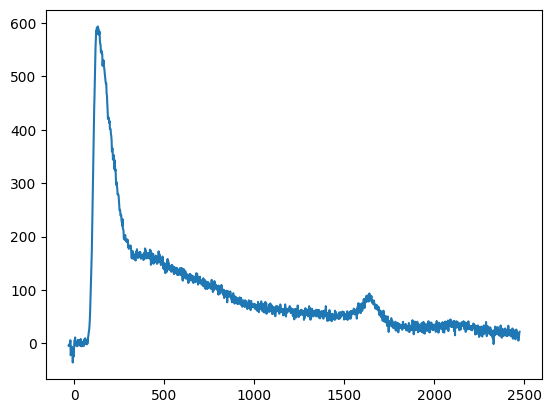

In [ ]:
plt.plot(f_sup, np.mean(colloids, axis=0))

In [ ]:
test_car = np.copy(spectra_dataset[0])
test_coll = np.copy(colloids[0])
# test_car = test_car / np.max(test_car)
# test_coll = test_coll / np.max(test_coll)

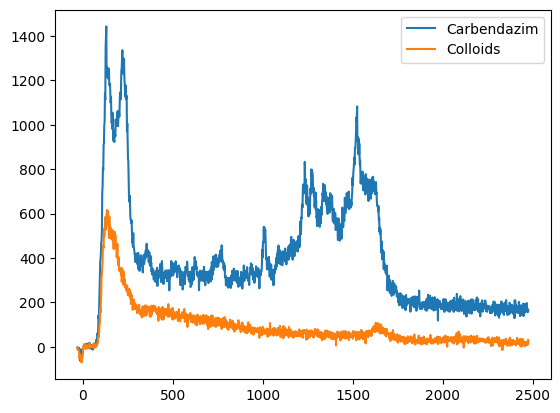

In [ ]:
plt.plot(f_sup, test_car, label="Carbendazim")
plt.plot(f_sup, test_coll, label="Colloids")
# plt.plot(f_sup, test_car - test_coll, label="Carbendazim - Colloids")
plt.legend()
plt.show()

In [ ]:
test_car

array([-0.002079  , -0.00831601, -0.00970201, ...,  0.10810811,
        0.10949411,  0.11226611])

In [ ]:
test_coll

array([-0.00811688, -0.01136364, -0.01623377, ...,  0.01623377,
        0.05032468,  0.03084416])

In [ ]:
print(test.shape)
print(colloids.shape)

(1600,)
(100, 1600)


In [ ]:
proj = (np.dot(test_coll, test_car)) / (np.linalg.norm(test_coll,ord=2)**2) * test_coll

In [ ]:
print(proj)

[-14.89917335 -20.8588427  -29.79834671 ...  29.79834671  92.37487479
  56.61685874]


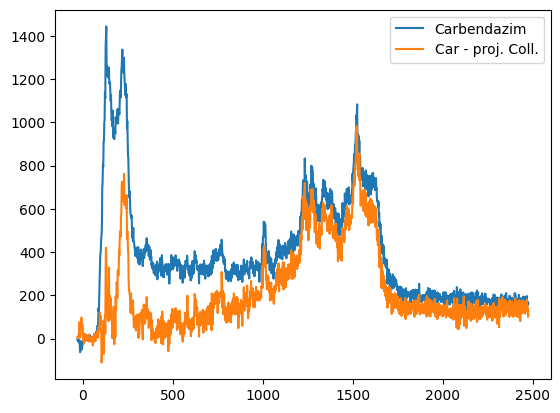

In [ ]:
plt.plot(f_sup, test_car, label="Carbendazim")
# plt.plot(f_sup, proj / 1.6, label="Proj")
# plt.plot(f_sup, test_coll, label="Colloids")
plt.plot(f_sup, test_car - (proj / 1.6), label="Car - proj. Coll.")
plt.legend()
plt.show()

In [ ]:
# Print the shape of the dataset
print(spectra_dataset.shape)

## Label mask

In [11]:
label_mask = np.zeros((73312))

label_mask[0:7500] = 1
label_mask[7500:15000] = 2
label_mask[15000:22500] = 3
label_mask[22500:30000] = 4
label_mask[30000:37500] = 5
label_mask[37500:44668] = 6
label_mask[44668:47740] = 7
label_mask[47740:] = 8

In [10]:
label_mask = np.zeros((73312, 4))

label_mask[0:7500] = [1, 0, 0, 0]
label_mask[7500:15000] = [0, 1, 0, 0]
label_mask[15000:22500] = [0, 0, 1, 0]
label_mask[22500:30000] = [1, 1, 0, 0]
label_mask[30000:37500] = [1, 0, 1, 0]
label_mask[37500:44668] = [0, 1, 1, 0]
label_mask[44668:47740] = [1, 1, 1, 0]
label_mask[47740:] = [0, 0, 0, 1]

## Constant component PCA Analysis

In [11]:
signals = np.zeros((73312, 5))

# Generate signals
for step in range(4):
    for i in range(73312):
        if label_mask[i][step] == 1:
            # Count the number of active labels at this step
            num_active_labels = sum(label_mask[i])
            signals[i][step] = 1 / num_active_labels if num_active_labels > 0 else 1

In [12]:
signals[:, 4] = 1

In [ ]:
signals_wo_nan = signals[~np.isnan(normalized_spectra).any(axis=1)]

In [ ]:
singals_wo_neg = signals_wo_nan[~(normalized_spectra_wo_nan[:, 50:] < 0).any(axis=1)]

In [ ]:
signals = signals.T

In [13]:
# Define class labels
class_labels = ["Carbendazim", "Thiacloprid", "Acetamiprid", "MG"]#, "Constant Component"]

IndexError: list index out of range

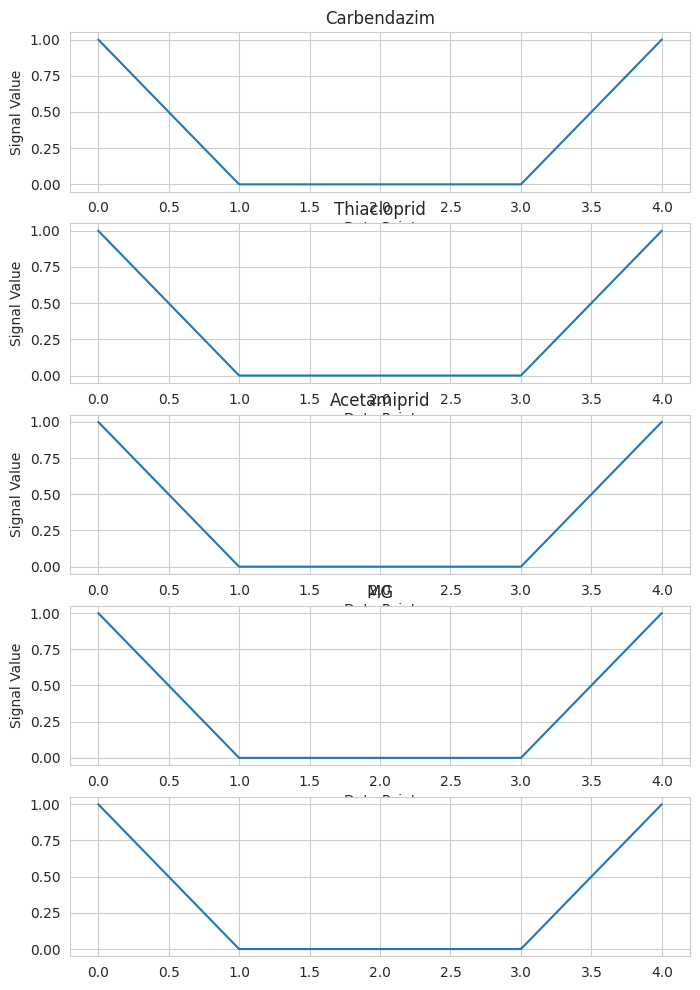

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 12))

# Define labels for the subplots
labels = ["Label 1", "Label 2", "Label 3", "Label 4"]

# Plot each entry in the 'signals' array in separate subplots
for i in range(5):
    axes[i].plot(signals[i])
    axes[i].set_title(class_labels[i])
    axes[i].set_xlabel("Data Point")
    axes[i].set_ylabel("Signal Value")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
#minimize function define
# t_data: pca_components from t_dataN_PCA
# time_data_input: programming curve
def f3(initial_guess,t_data,time_data_input):
    result = np.zeros(time_data_input.size)
    for i in range(len(initial_guess)):
        result += np.dot(initial_guess[i],t_data[:,i])
    return np.linalg.norm(result-time_data_input)

In [ ]:
signals_wo_nan.shape

(72782, 5)

In [ ]:
plt.plot(signals_wo_nan.T)

IndexError: ignored

In [ ]:
#Use minimize function
result_car_pca = minimize(f3, [1, 1, 1, 1, 1],args=(f_dataN_PCA, signals_wo_nan.T[0] * 0.01), tol = 10**-12)

In [ ]:
result_aceta_pca = minimize(f3, [1, 1, 1, 1, 1],args=(f_dataN_PCA, signals_wo_nan.T[2] * 0.01), tol = 10**-12)

In [ ]:
result_car_aceta_pca = minimize(f3, [1, 1, 1, 1, 1],args=(f_dataN_PCA, signals_wo_nan.T[0] * 0.01), tol = 10**-12)

In [ ]:
result_mg_pca = minimize(f3, [1, 1, 1, 1, 1],args=(f_dataN_PCA, signals_wo_nan.T[3] * 0.01), tol = 10**-12)

In [ ]:
dir(result)

['fun',
 'hess_inv',
 'jac',
 'message',
 'nfev',
 'nit',
 'njev',
 'status',
 'success',
 'x']

In [ ]:
# plt.plot(result.x)
result.x / np.linalg.norm(result.x)

array([-0.42575429, -0.37004025, -0.33424559, -0.7034562 , -0.27428592])

In [ ]:
f_dataN_PCA.shape

(72782, 4)

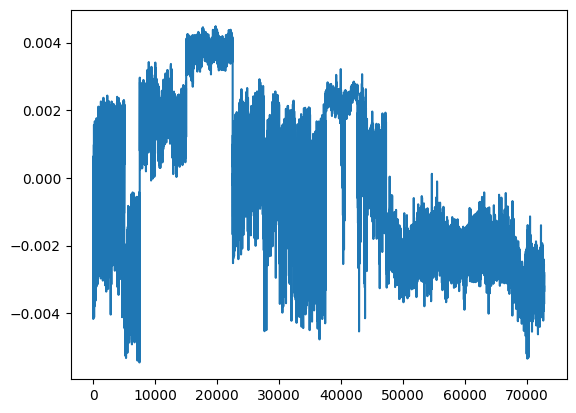

In [ ]:
# t_dataN_PCA.shape
plt.plot(np.dot(result_aceta_pca.x, f_dataN_PCA.T))

## Multilabel test

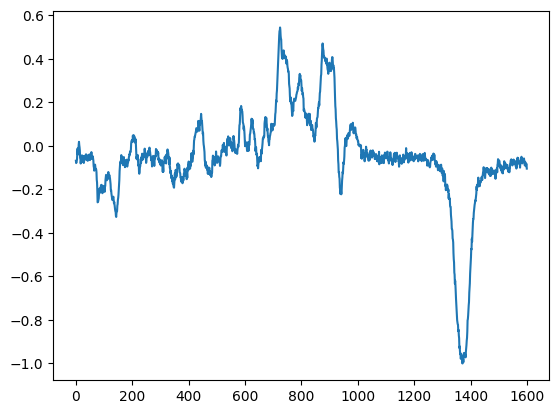

In [ ]:
plt.plot(np.dot(result_car_pca.x, t_dataN_PCA) / np.max(np.dot(result_car_pca.x, -1 * t_dataN_PCA)))
# plt.plot(normalized_spectra_wo_nan[-1])

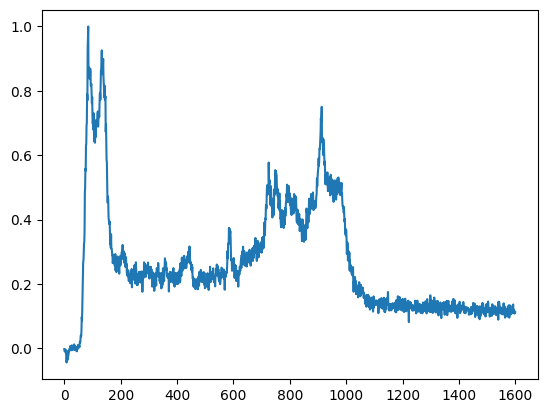

In [ ]:
plt.plot(normalized_spectra_wo_nan[0])

In [ ]:
t_dataN_PCA.shape

(5, 1600)

In [ ]:
f_dataN_PCA.shape

(72782, 5)

In [ ]:
#Use minimize function
result_car_nmf = minimize(f3, [1, 1, 1, 1, 1],args=(f_dataN_NMF, singals_wo_neg.T[0] * 0.01), tol = 10**-12)

In [ ]:
result_aceta_nmf = minimize(f3, [1, 1, 1, 1, 1],args=(f_dataN_NMF, singals_wo_neg.T[2] * 0.01), tol = 10**-12)

In [ ]:
result_mg_nmf = minimize(f3, [1, 1, 1, 1, 1],args=(f_dataN_NMF, singals_wo_neg.T[3] * 0.01), tol = 10**-12)

In [ ]:
result_cc_nmf = minimize(f3, [1, 1, 1, 1, 1],args=(f_dataN_NMF, singals_wo_neg.T[-1] * 0.01), tol = 10**-12)

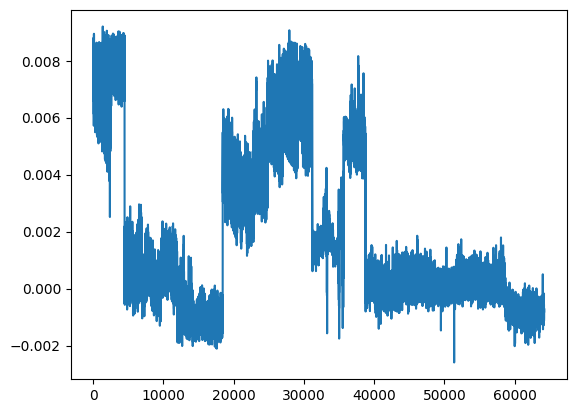

In [ ]:
# t_dataN_PCA.shape
plt.plot(np.dot(result_car_nmf.x, f_dataN_NMF.T))

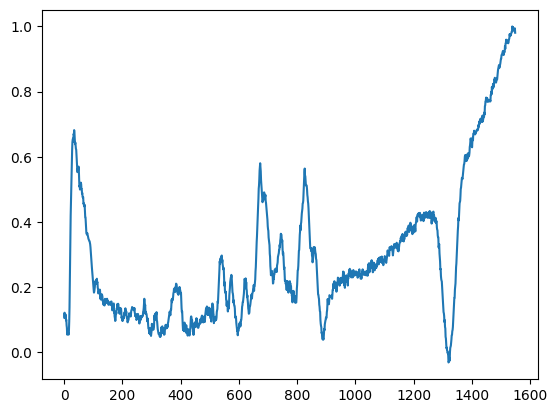

In [ ]:
plt.plot(np.dot(result_car_nmf.x, t_dataN_NMF) / np.max(np.dot(result_car_nmf.x, t_dataN_NMF)))
# plt.plot(normalized_spectra_wo_nan[-1])

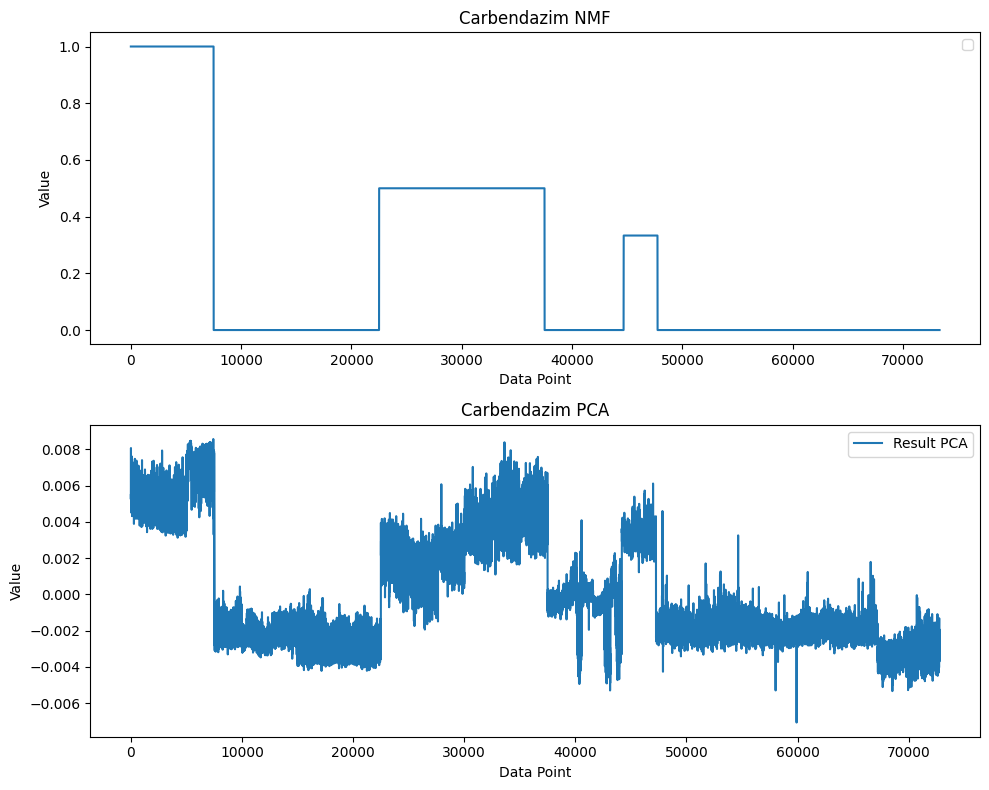

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the first line on the first subplot
# axes[0].plot(np.dot(result_car_nmf.x, f_dataN_NMF.T), label='Result NMF')
axes[0].plot(signals[0])

# Plot the second line on the second subplot
axes[1].plot(np.dot(result_car_pca.x, f_dataN_PCA.T), label='Result PCA')

# Set titles and labels
axes[0].set_title('Carbendazim NMF')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Value')

axes[1].set_title('Carbendazim PCA')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')

# Add a legend to distinguish the two lines
axes[0].legend()
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

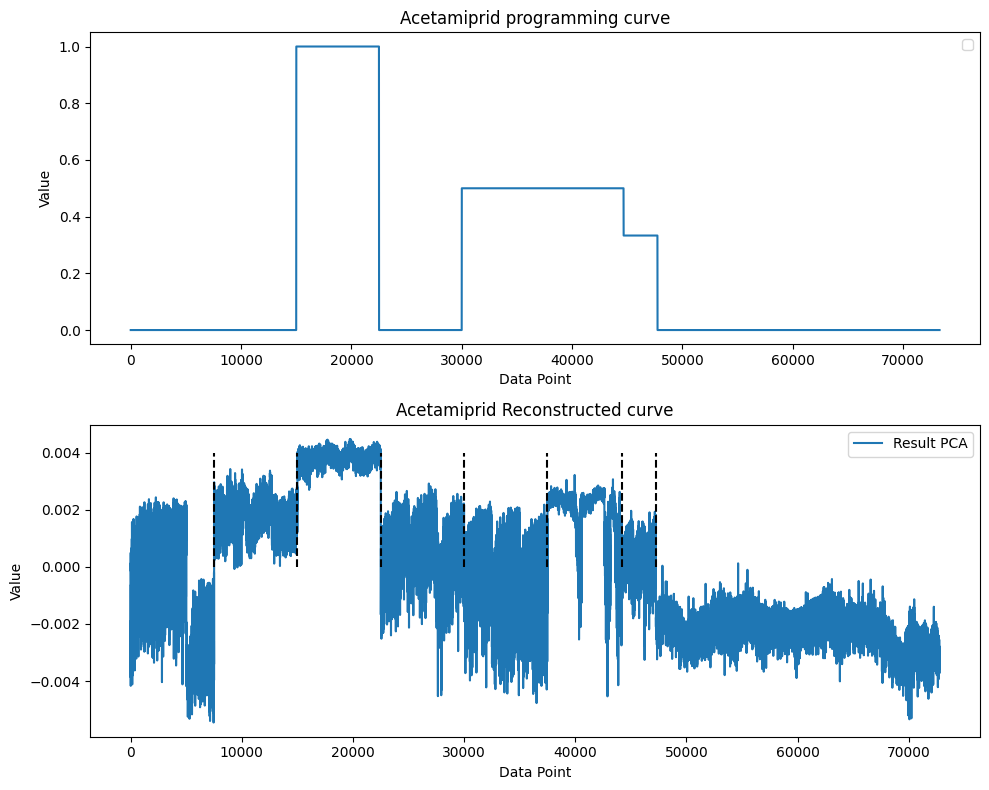

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the first line on the first subplot
# axes[0].plot(np.dot(result_aceta_nmf.x, f_dataN_NMF.T), label='Result NMF')
axes[0].plot(signals[2])


# Plot the second line on the second subplot
axes[1].plot(np.dot(result_aceta_pca.x, f_dataN_PCA.T), label='Result PCA')

axes[1].vlines(x=[7500, 15000, 22500, 30000, 37500, 44188, 47260], ymin=0, ymax=0.004, colors="k", linestyles="dashed")

# Set titles and labels
axes[0].set_title('Acetamiprid programming curve')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Value')

axes[1].set_title('Acetamiprid Reconstructed curve')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')

# Add a legend to distinguish the two lines
axes[0].legend()
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

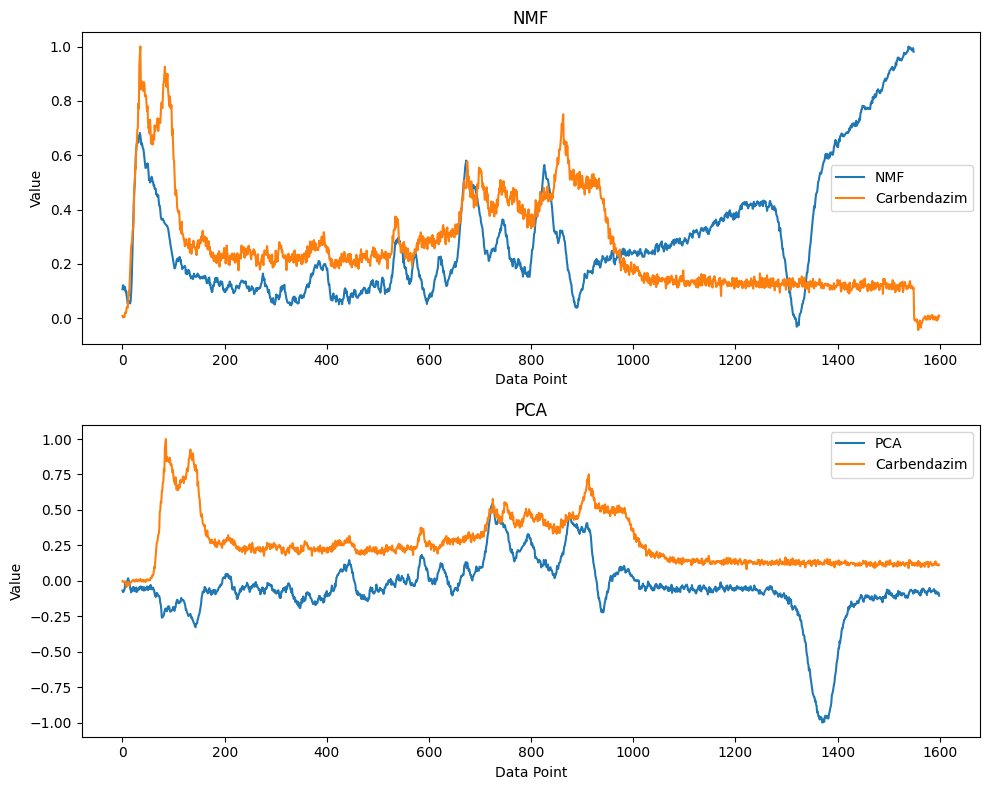

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(np.dot(result_car_nmf.x, t_dataN_NMF) / np.max(np.dot(result_car_nmf.x, t_dataN_NMF)), label='NMF')
axes[0].plot(np.roll(normalized_spectra_wo_negative[0], -50), label='Carbendazim')

axes[1].plot(np.dot(result_car_pca.x, t_dataN_PCA) / np.max(np.dot(result_car_pca.x, -1 * t_dataN_PCA)), label='PCA')
axes[1].plot(normalized_spectra_wo_nan[0], label='Carbendazim')

# Set titles and labels
axes[0].set_title('NMF')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Value')

axes[1].set_title('PCA')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')

# Add a legend to distinguish the two lines
axes[0].legend()
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

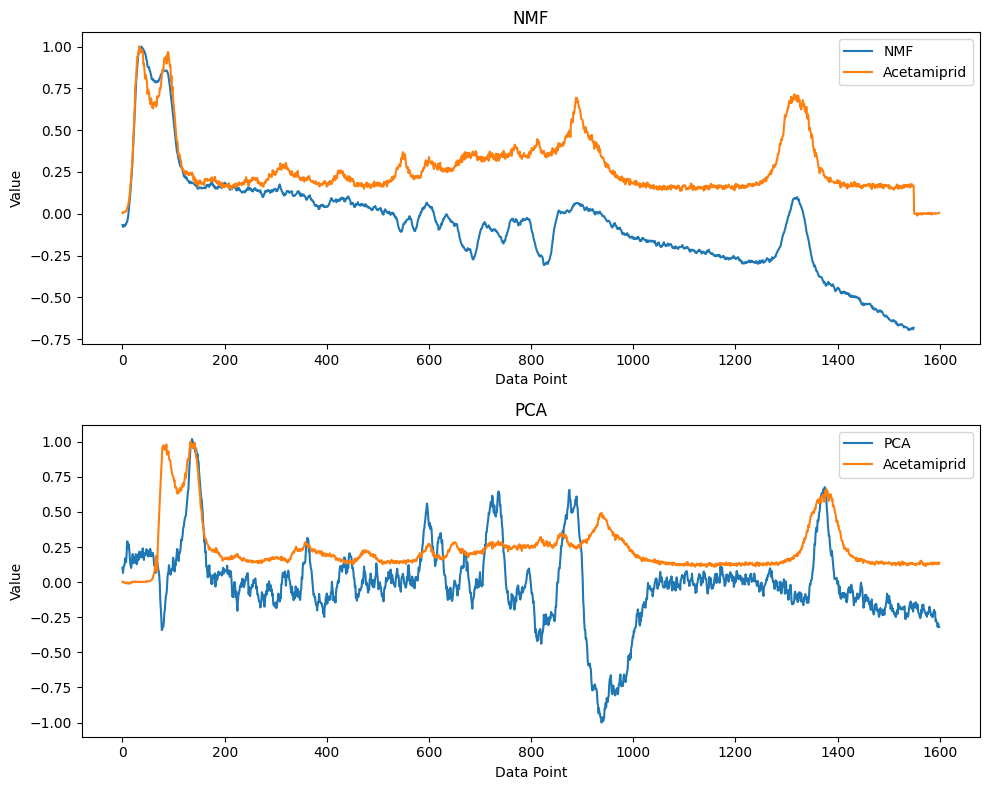

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(np.dot(result_aceta_nmf.x, t_dataN_NMF) / np.max(np.dot(result_aceta_nmf.x, t_dataN_NMF)), label='NMF')
axes[0].plot(np.roll(normalized_spectra_wo_negative[7600], -50), label='Acetamiprid')

axes[1].plot(np.dot(result_aceta_pca.x, t_dataN_PCA) / np.max(np.dot(result_aceta_pca.x, -1 * t_dataN_PCA)), label='PCA')
axes[1].plot(normalized_spectra_wo_nan[7600], label='Acetamiprid')

# Set titles and labels
axes[0].set_title('NMF')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Value')

axes[1].set_title('PCA')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')

# Add a legend to distinguish the two lines
axes[0].legend()
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

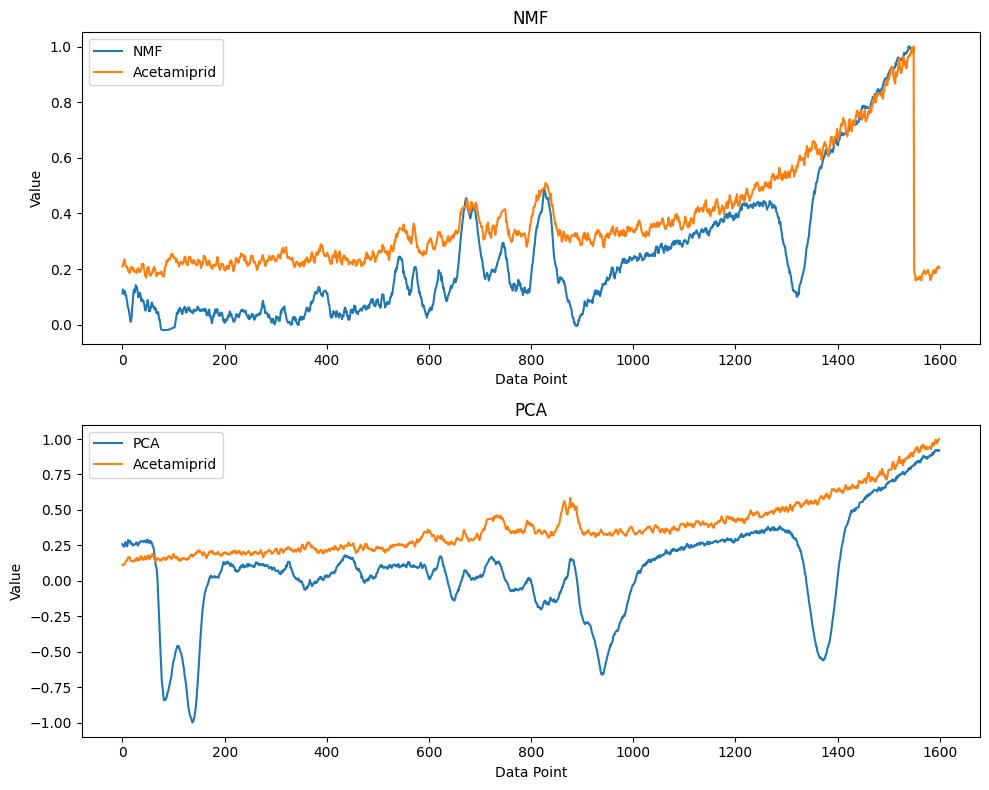

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(np.dot(result_mg_nmf.x, t_dataN_NMF) / np.max(np.dot(result_mg_nmf.x, t_dataN_NMF)), label='NMF')
axes[0].plot(np.roll(normalized_spectra_wo_negative[50000], -50), label='Acetamiprid')

axes[1].plot(np.dot(result_mg_pca.x, t_dataN_PCA) / np.max(np.dot(result_mg_pca.x, -1 * t_dataN_PCA)), label='PCA')
axes[1].plot(normalized_spectra_wo_nan[50000], label='Acetamiprid')

# Set titles and labels
axes[0].set_title('NMF')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Value')

axes[1].set_title('PCA')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')

# Add a legend to distinguish the two lines
axes[0].legend()
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Generate synthetic multi-label dataset
X, y = make_multilabel_classification(n_samples=100, n_features=10, n_classes=5, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define class labels
class_labels = ["ant", "bird", "cat", "dolphin", "bee"]

In [ ]:
X.shape
print(y)

In [ ]:
# Create a multi-label classifier
classifier = MultiOutputClassifier(KNeighborsClassifier())

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

In [ ]:
hamming_loss(y_test, y_pred)

0.21

In [ ]:
# Calculate accuracy and Hamming loss
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)
j_score = jaccard_score(y_test, y_pred, average='samples')

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)
print(f'Jaccard Score: {j_score}')

Accuracy: 0.3
Hamming Loss: 0.21
Jaccard Score: 0.6


In [ ]:
# Print confusion matrices for each label
for i in range(len(confusion_matrices)):
    print(f"Confusion Matrix for Label {i}:\n{confusion_matrices[i]}")

In [ ]:
# Visualize confusion matrices for each label
for i in range(len(confusion_matrices)):
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrices[i], annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"Confusion Matrix for {class_labels[i]}")
    plt.show()

In [ ]:
# Create a custom confusion matrix
unique_labels = np.unique(class_labels)
confusion_matrix = np.zeros((len(unique_labels) + 1, len(unique_labels) + 1), dtype=int)

for i, true_label in enumerate(y_test):
    for j, pred_label in enumerate(y_pred):
        for k, label in enumerate(unique_labels):
            if true_label[k] == 1 and pred_label[k] == 1:
                # True positive
                confusion_matrix[k, k] += 1
            elif true_label[k] == 1 and pred_label[k] == 0:
                # False negative
                confusion_matrix[k, -1] += 1
            elif true_label[k] == 0 and pred_label[k] == 1:
                # False positive
                confusion_matrix[-1, k] += 1

# Print the custom confusion matrix
print("Custom Confusion Matrix:")
print(confusion_matrix)

Custom Confusion Matrix:
[[ 20   0   0   0   0  60]
 [  0  90   0   0   0  90]
 [  0   0 117   0   0  63]
 [  0   0   0  63   0  77]
 [  0   0   0   0   6  54]
 [ 80 110 143 117  34   0]]


In [ ]:
# Plot the mean of the dataset that are 1 in the label mask
plt.plot(f_sup, np.mean(spectra_dataset_baselined[label_mask == 3], axis=0))

In [ ]:
# Plot all the spectra that are 1 in the label mask
plt.plot(spectra_dataset[label_mask == 1].T);

In [ ]:
# plt.plot(f_sup, spectra_dataset_sg[label_mask == 1].T);
plt.plot(f_sup, spectra_dataset_sg[0]);

In [ ]:
# Baseline stimation with asymmetric least squares
# According to paper: "Baseline Correction with Asymmetric Least Squares Smoothing"
# by Paul H. C. Eilers and Hans F.M. Boelens. October 21, 2005

# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Baseline stimation function:
def baseline_als(y, lam, p, niter=100):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [ ]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

In [ ]:
sparse.diags([1,-2,1],[0,-1,-2], shape=(1600,1600-2))

<1600x1598 sparse matrix of type '<class 'numpy.float64'>'
	with 4794 stored elements (3 diagonals) in DIAgonal format>

In [ ]:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.05 # asymmetry

In [ ]:
# Estimation of the baseline:
estimated_baselined = baseline_als(spectra_dataset[0], l, p)

# Baseline subtraction:
baselined_spectrum = spectra_dataset[0] - estimated_baselined

# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(f_sup, spectra_dataset[0], color = 'black', label = 'Mix spectrum with noise' )
ax1.plot(f_sup, estimated_baselined, color = 'red', label = 'Estimated baseline')
ax1.set_title('Baseline estimation', fontsize = 15)
ax1.set_xlabel('Wavelength', fontsize = 15)
ax1.set_ylabel('Intensity',  fontsize = 15)
ax1.legend()

# We plot the mix spectrum after baseline subtraction
ax2.plot(f_sup, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
ax2.set_title('Baselined spectrum', fontsize = 15)
ax2.set_xlabel('Wavelength', fontsize = 15)
ax2.set_ylabel('Intensity',  fontsize = 15)
plt.show()

In [ ]:
estimated_baselined.shape

(1600,)

In [ ]:
# Estimate the baseline for all the spectra in the dataset using the function baseline_als
# Create a separate variable called spectra_dataset_baselined

spectra_dataset_baselined = np.zeros((73312, 1600))

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

def compute_baseline(idx):
    if idx % 100 == 0:
        print("Processing spectrum", idx)
    return baseline_als(spectra_dataset[idx], l, p)

num_cores = multiprocessing.cpu_count()
spectra_dataset_baselined = Parallel(n_jobs=num_cores)(delayed(compute_baseline)(idx) for idx in range(len(spectra_dataset)))
spectra_dataset_baselined = spectra_dataset - np.array(spectra_dataset_baselined)

In [ ]:
# Plot the mean of the dataset that are 1 in the label mask from idx 300 till end
plt.plot(f_sup[300:], np.mean(spectra_dataset_baselined[0:7500, 300:], axis=0))

In [ ]:
# Plot all the spectra that are 1 in the label mask from index 200 till end
plt.plot(spectra_dataset_baselined[label_mask == 1][200:].T);

In [ ]:
scaler = StandardScaler()

In [ ]:
min_max_scaler = MinMaxScaler()

In [ ]:
scaled_dataset = np.zeros_like(spectra_dataset)

In [ ]:
# Fit the scaler to the dataset and transform the dataset where the label mask is 1
scaled_dataset[label_mask == 1] = scaler.fit_transform(spectra_dataset[label_mask == 1])

In [ ]:
# Fit the min_max_scaler to the dataset and transform the dataset where the label mask is 1
scaled_dataset[label_mask == 1] = min_max_scaler.fit_transform(spectra_dataset[label_mask == 1])

In [ ]:
plt.plot(f_sup, scaled_dataset[0])

In [ ]:
plt.plot(f_sup, spectra_dataset[0])

In [ ]:
plt.plot(f_sup, normalized_spectra[0])

## Normalize spectra

In [11]:
max_values = np.max(spectra_dataset, axis=1)  # Get the maximum value for each spectrum
normalized_spectra = spectra_dataset / max_values[:, np.newaxis]  # Divide each spectrum by its maximum value

/tmp/ipykernel_134615/3677515084.py:2: RuntimeWarning: invalid value encountered in divide
  normalized_spectra = spectra_dataset / max_values[:, np.newaxis]  # Divide each spectrum by its maximum value


In [14]:
normalized_spectra_wo_nan = normalized_spectra[~np.isnan(normalized_spectra).any(axis=1)]

# Remove the values with the same index from the label mask
label_mask_wo_nan = label_mask[~np.isnan(normalized_spectra).any(axis=1)]

In [15]:
# Apply the same mask to label_mask and normalized_spectra arrays
label_mask_wo_negative = label_mask_wo_nan[~(normalized_spectra_wo_nan[:, 50:] < 0).any(axis=1)]
normalized_spectra_wo_negative = normalized_spectra_wo_nan[~(normalized_spectra_wo_nan[:, 50:] < 0).any(axis=1)]

In [ ]:
(normalized_spectra[0][50:] < 0).any()

False

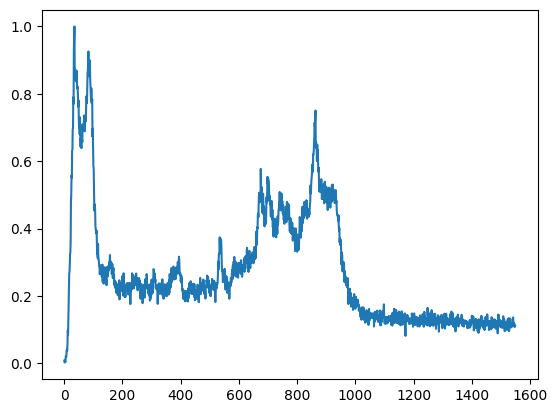

In [ ]:
plt.plot(normalized_spectra[0][50:])

In [ ]:
# Assuming you have label_mask_wo_negative after removing entries with negative values

# Count the occurrences of each label in the remaining data
label_counts = np.sum(label_mask_wo_negative, axis=0)

# Calculate the total number of remaining entries
total_entries = label_mask_wo_negative.shape[0]

# Calculate the percentage of each label
label_percentages = (label_counts / total_entries) * 100

# Display or use the label_percentages as needed
print("Label Percentages:")
for i, percentage in enumerate(label_percentages):
    print(f"Label {i+1}: {percentage:.2f}%")

Label Percentages:
Label 1: 31.54%
Label 2: 33.40%
Label 3: 31.82%
Label 4: 39.66%


In [ ]:
normalized_spectra_wo_negative.shape

(64218, 1600)

In [ ]:
# plt.plot(normalized_spectra_wo_nan[1, 100:])
normalized_spectra_wo_nan[1, 100:]

array([0.72633745, 0.73662551, 0.71604938, ..., 0.10185185, 0.09670782,
       0.0936214 ])

# Machine Learning

## NMF

In [ ]:
n_components= 5
model = NMF(n_components)
W_NMF = model.fit_transform(normalized_spectra_wo_negative[:, 50:])
H_NMF = model.components_
t_dataN_NMF = H_NMF
f_dataN_NMF = W_NMF

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


## PCA

In [ ]:
n_components= 5
model = PCA(n_components)
W_PCA = model.fit_transform(normalized_spectra_wo_nan)
H_PCA = model.components_
t_dataN_PCA = H_PCA
f_dataN_PCA = W_PCA

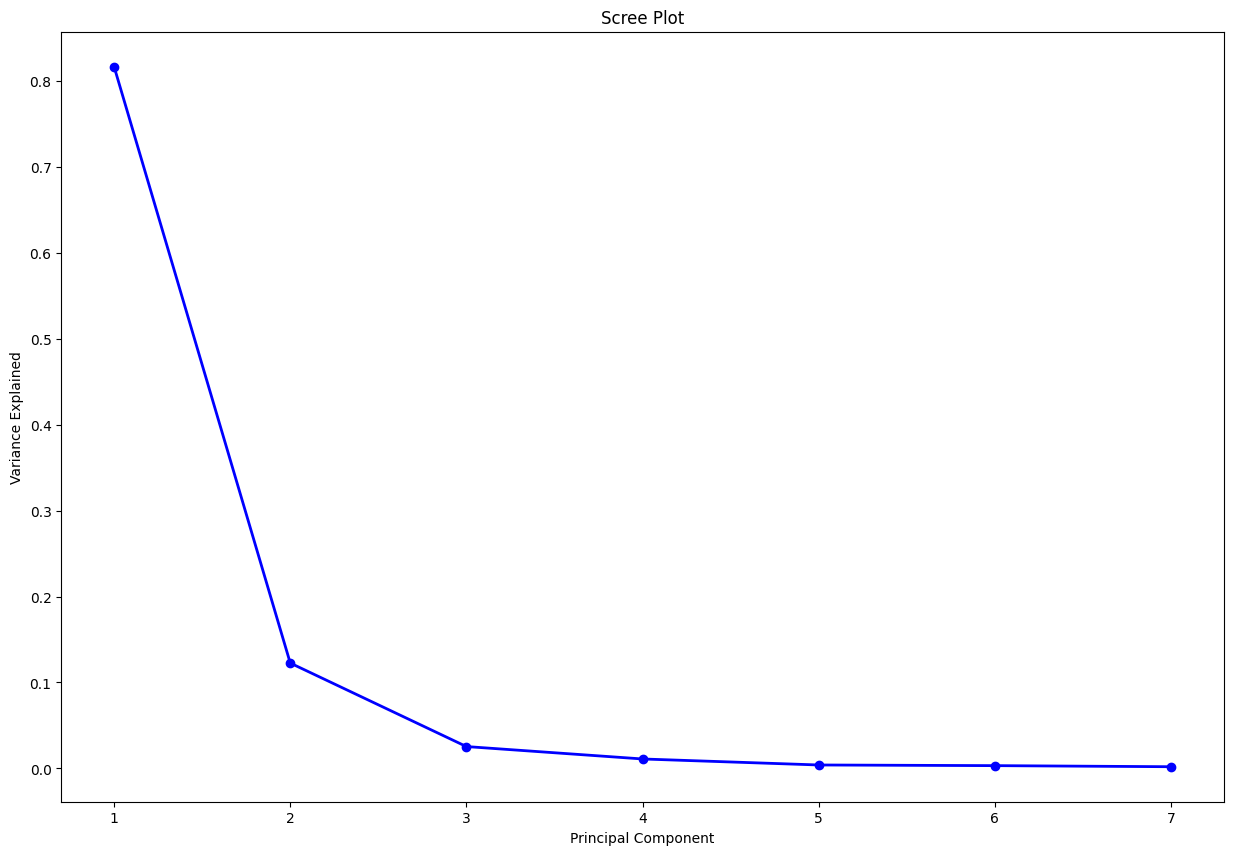

In [ ]:
PC_values = np.arange(model.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, model.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

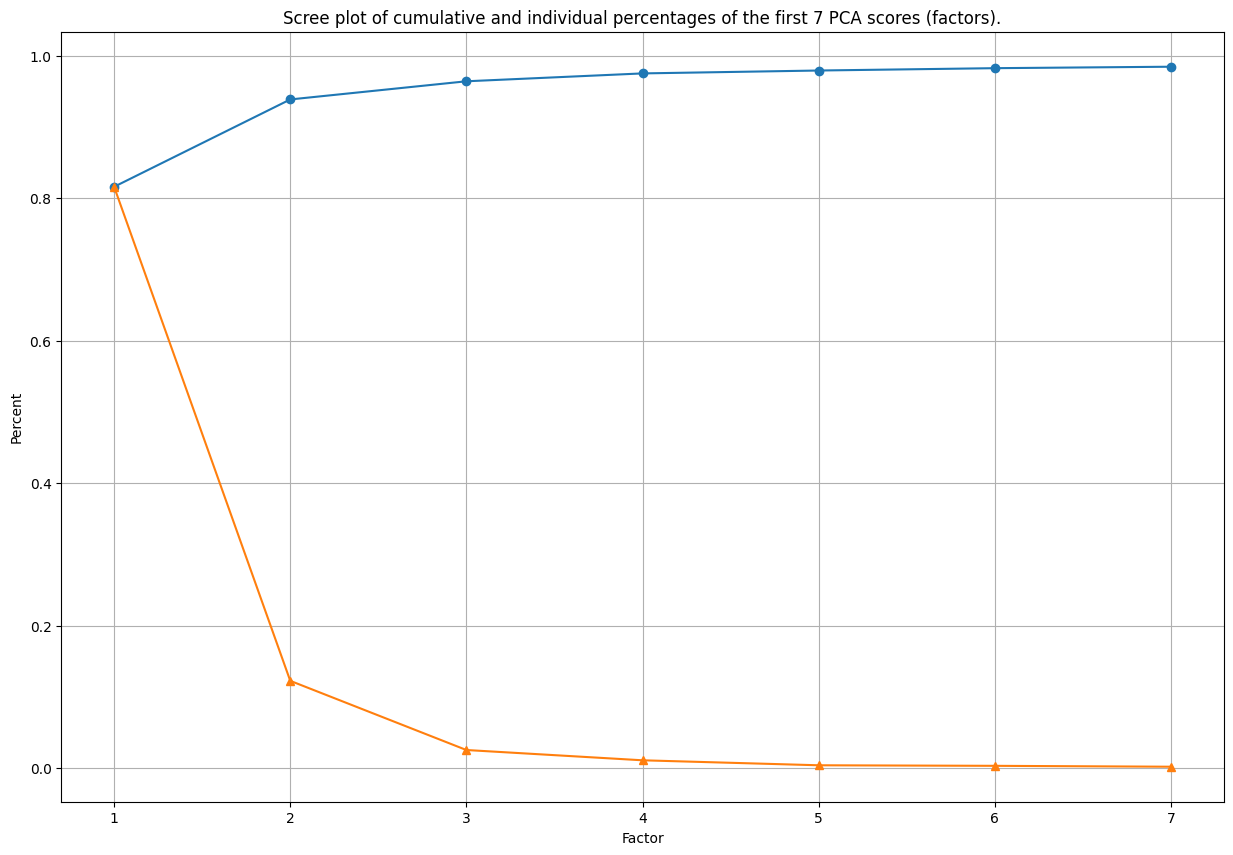

In [ ]:
explained_variance_ratio = model.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot individual explained variance
plt.figure(figsize=(15, 10))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='-', label='Cumulative percent')
plt.plot(range(1, n_components + 1), explained_variance_ratio, marker='^', linestyle='-', label='Individual percent')
plt.xlabel('Factor')
plt.ylabel('Percent')
plt.title('Scree plot of cumulative and individual percentages of the first 7 PCA scores (factors).')
plt.grid()
plt.show()

## Programmable curve for PCA

In [ ]:
scree_data = np.column_stack((np.arange(1, n_components + 1), explained_variance_ratio, cumulative_explained_variance))

np.savetxt('pca_explained_variance.csv', scree_data, delimiter=',', header='Range,Explained Variance Ratio,Cumulative Explained Variance', comments='')

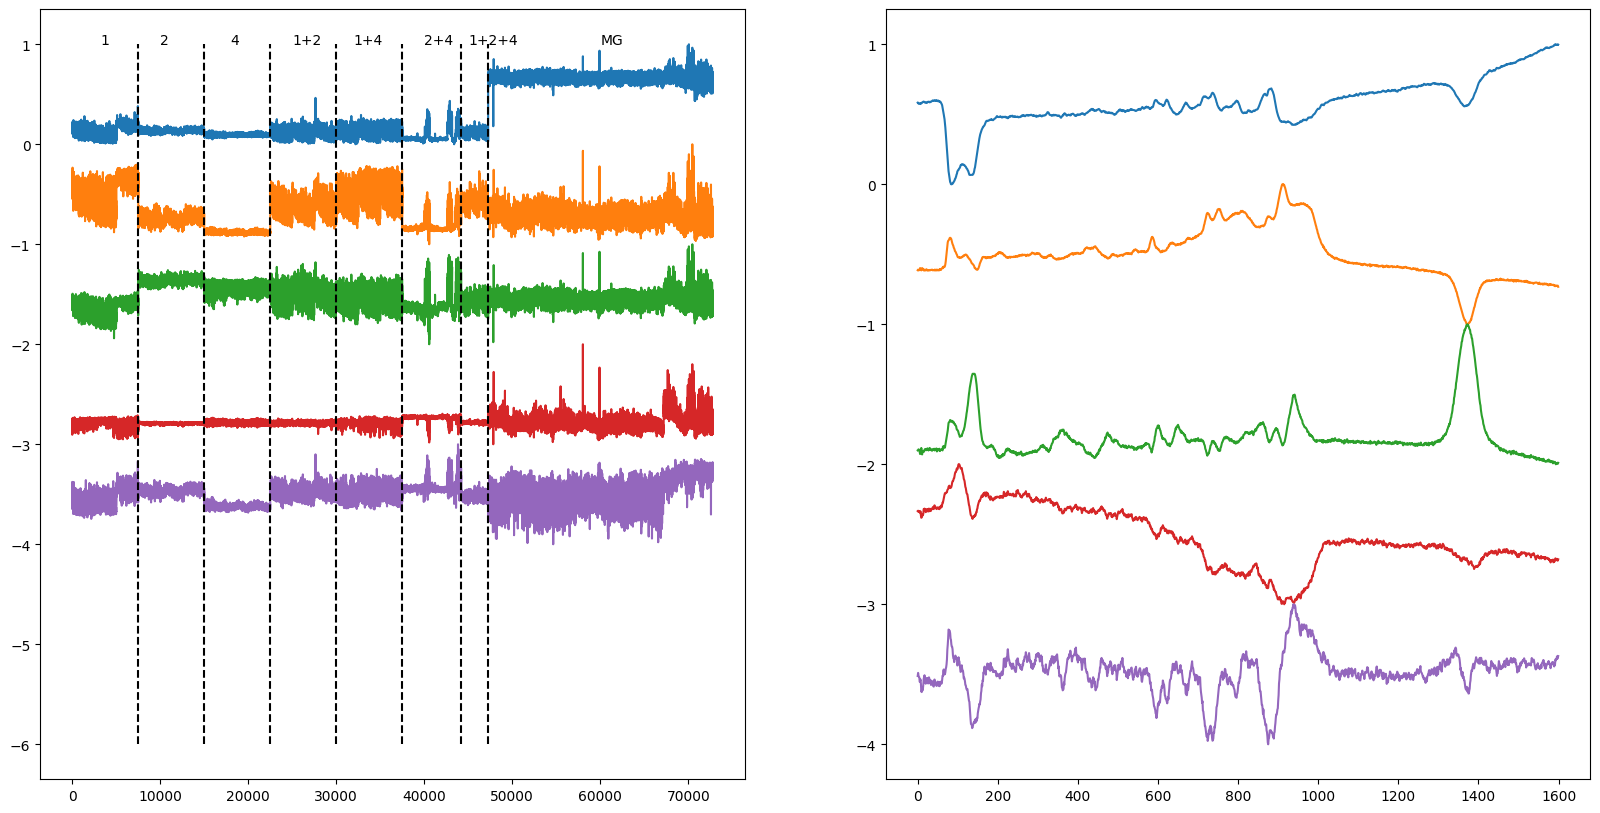

In [ ]:
# Plot the first subplot
plt.figure(figsize = (20, 10))
plt.subplot(121)
for i in range(n_components):
    # Normalize and plot each column of f_dataN_PCA
    plt.plot((f_dataN_PCA[:,i]-min(f_dataN_PCA[:,i]))/np.mean(max(f_dataN_PCA[:,i])-min(f_dataN_PCA[:,i]))-i)

# Add vertical lines and text labels
plt.vlines(x=[7500, 15000, 22500, 30000, 37500, 44188, 47260], ymin=-6, ymax=1, colors="k", linestyles="dashed")
plt.text(3250,1,"1")
plt.text(10000,1,"2")
plt.text(18000,1,"4")
plt.text(25000,1,"1+2")
plt.text(32000,1,"1+4")
plt.text(40000,1,"2+4")
plt.text(45000,1,"1+2+4")
plt.text(60000,1,"MG")

# Plot the second subplot
plt.subplot(122)
for i in range(n_components):
    # Normalize and plot each row of t_dataN_PCA
    plt.plot(((t_dataN_PCA[i]-min(t_dataN_PCA[i]))/(max(t_dataN_PCA[i])-min(t_dataN_PCA[i]))-i))

plt.show()

## KNN

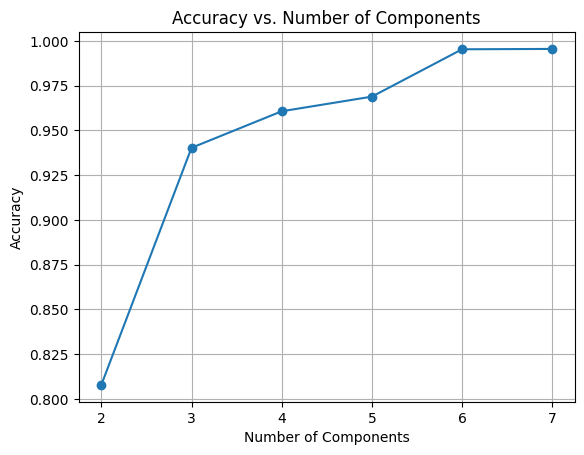

In [ ]:
# Assuming your dataset is stored in a numpy array called 'data' and the corresponding labels are stored in 'labels'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Define the range of components to test
components_range = range(2, 8)

# Initialize a list to store the accuracy results
accuracy_results = []

for n_components in components_range:
    # Perform PCA on the training set with the current number of components
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)

    # Fit a KNN classifier on the transformed training set
    knn = KNeighborsClassifier(n_neighbors=n_components)
    knn.fit(X_train_pca, y_train)

    # Transform the testing set using the same PCA object
    X_test_pca = pca.transform(X_test)

    # Predict the labels of the testing set using the trained KNN classifier
    y_pred = knn.predict(X_test_pca)

    # Calculate and store the accuracy for this number of components
    accuracy = np.mean(y_pred == y_test)
    accuracy_results.append(accuracy)

# Plot the accuracy results
plt.plot(components_range, accuracy_results, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xticks(components_range)
plt.grid(True)
plt.show()

In [ ]:
accuracy_table = []
accuracy_table.append(accuracy_results)

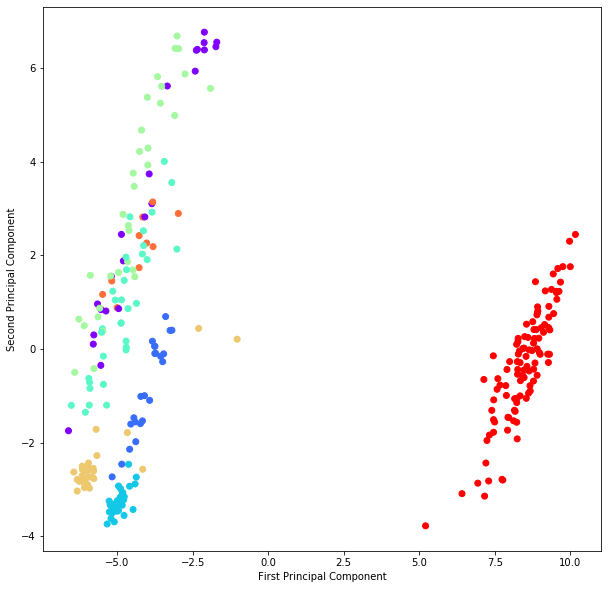

In [ ]:
# Create a scatter plot with every 200th point
plt.figure(figsize=(10, 10))
plt.scatter(X_train_pca[::200, 0], X_train_pca[::200, 1], c=y_train[::200], cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [ ]:
def scatter_plot_with_subset(X, y, num_points):
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Define the combinations of principal components
    combinations = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]

    labels = ["Car", "Thia", "Aceta", "Car+Thia", "Car+Aceta", "Thia+Aceta", "Car+Thia+Aceta", "MG"]

    for i, (pc1, pc2) in enumerate(combinations):
        row, col = i // 3, i % 3
        ax = axes[row, col]

        # Scatter plot with every num_points
        sc = ax.scatter(X[::num_points, pc1], X[::num_points, pc2], c=y[::num_points], cmap='rainbow')
        ax.set_xlabel(f'Principal Component {pc1 + 1}')
        ax.set_ylabel(f'Principal Component {pc2 + 1}')

        # Add a legend with labels
        handles, _ = sc.legend_elements(num=len(labels))
        ax.legend(handles, labels, title="Classes")

    plt.show()

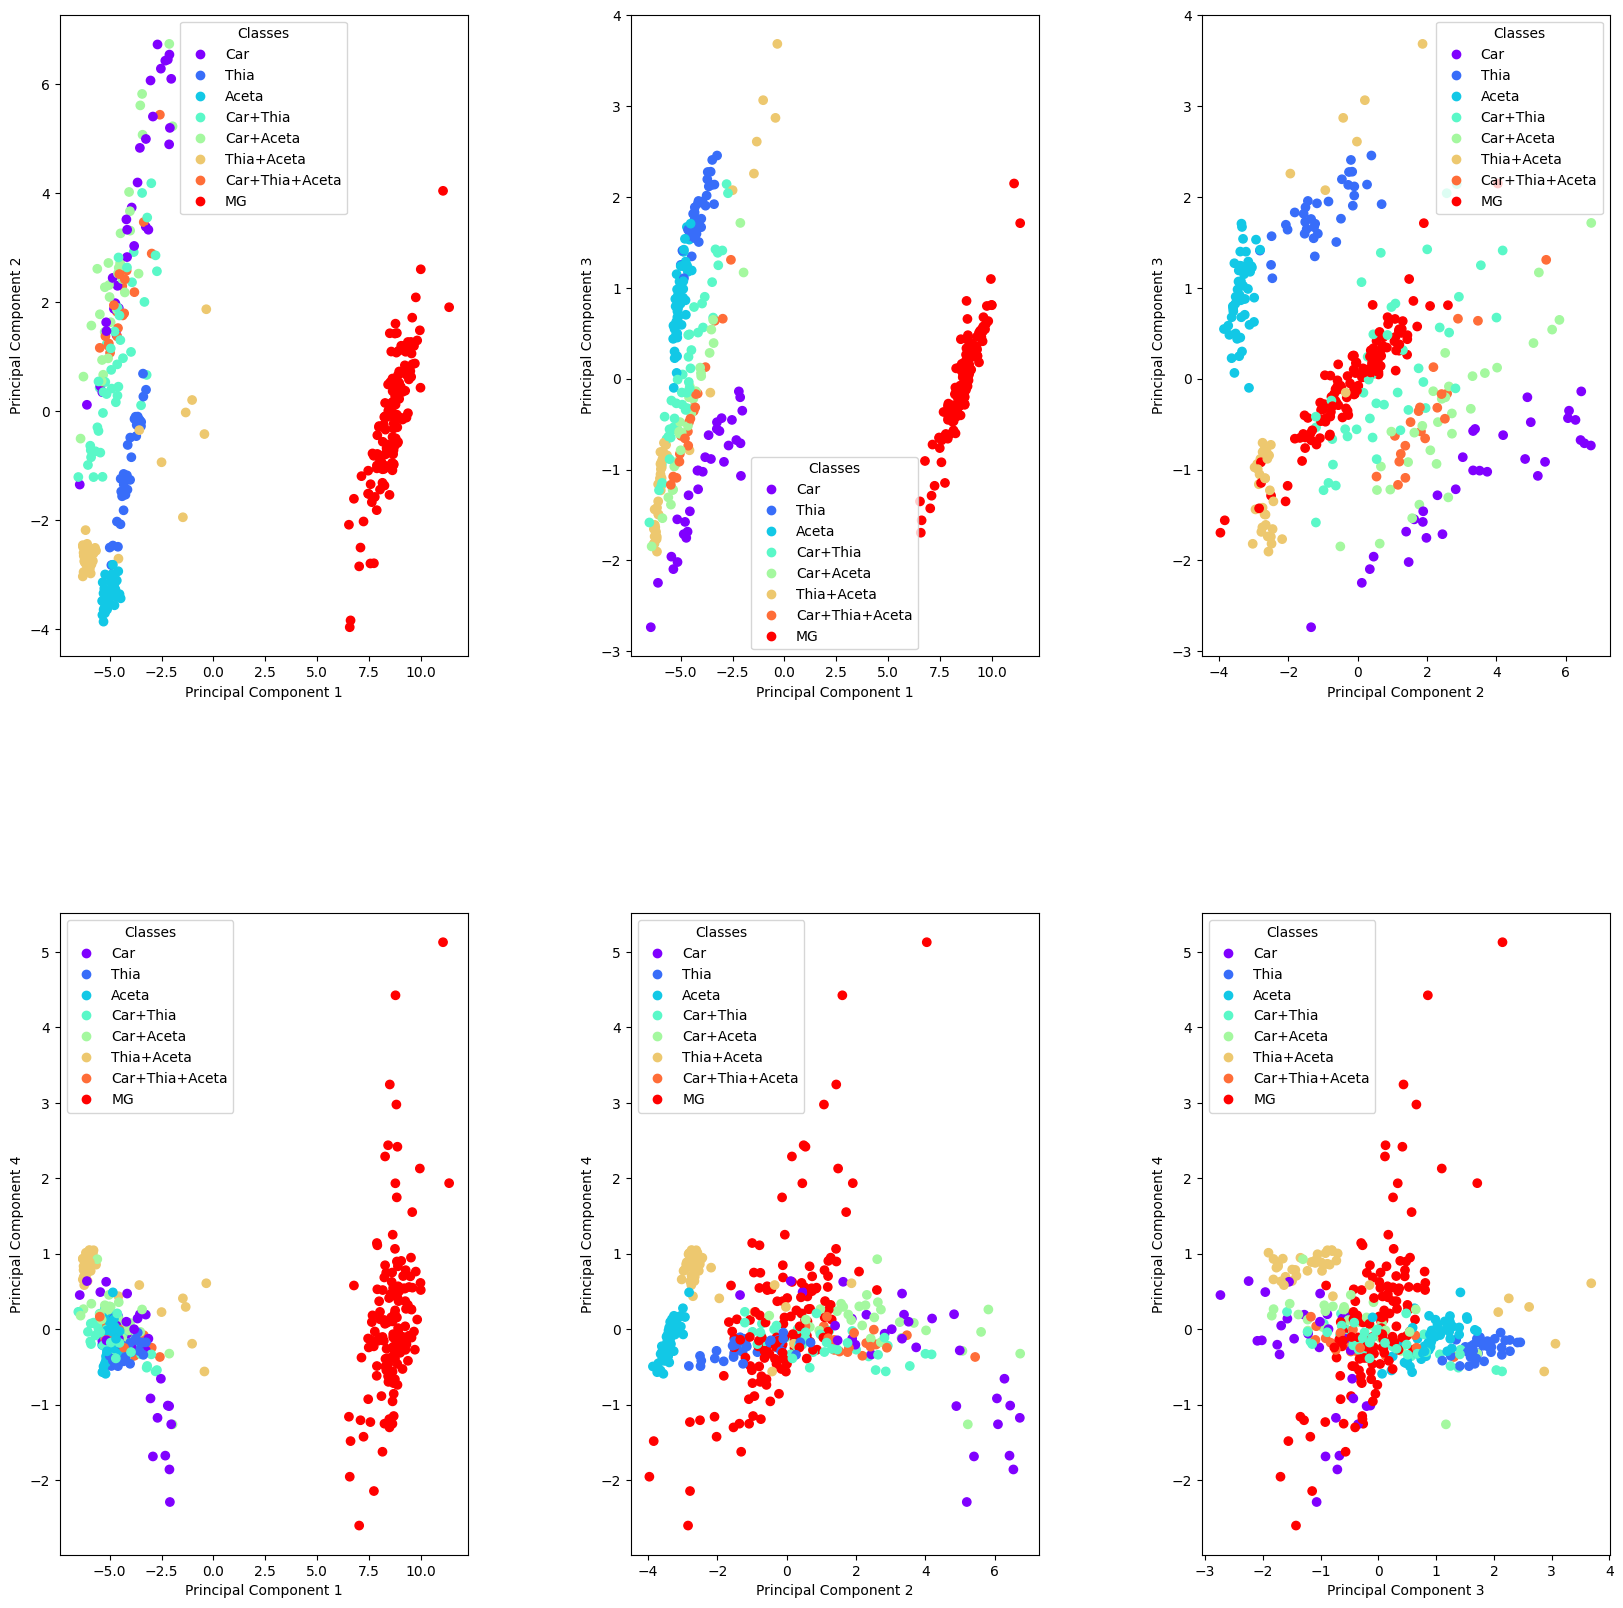

In [ ]:
# Call the function with the desired number of points
scatter_plot_with_subset(X_train_pca, y_train, num_points=150)

In [ ]:
X_train_pca.shape[0] / 150

388.1666666666667

In [ ]:
step = 150

# Create a file to save your CSV data
file_path = 'pca_results.csv'

# Choose every 150 points and transpose the data for column-wise storage
selected_data = X_train_pca[::step, :]
selected_labels = y_train[::step]

In [ ]:
selected_labels.shape
selected_data.shape

(389, 7)

In [ ]:
np.savetxt(file_path, np.column_stack((selected_data, selected_labels)), delimiter=',', fmt='%f', header="PC1, PC2, PC3, PC4, PC5, PC6, PC7, Labels")

In [ ]:
from sklearn.metrics import confusion_matrix

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Define the range of components to test
components_range = range(2, 8)

# Initialize lists to store accuracy and confusion matrix results
accuracy_results = []
confusion_matrix_results = []

for n_components in components_range:
    # Perform PCA on the training set with the current number of components
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)

    # Fit a KNN classifier on the transformed training set
    knn = KNeighborsClassifier(n_neighbors=n_components)
    knn.fit(X_train_pca, y_train)

    # Transform the testing set using the same PCA object
    X_test_pca = pca.transform(X_test)

    # Predict the labels of the testing set using the trained KNN classifier
    y_pred = knn.predict(X_test_pca)

    # Calculate and store the accuracy for this number of components
    accuracy = np.mean(y_pred == y_test)
    accuracy_results.append(accuracy)

    # Calculate and store the confusion matrix for this number of components
    confusion_matrix_results.append(confusion_matrix(y_test, y_pred))

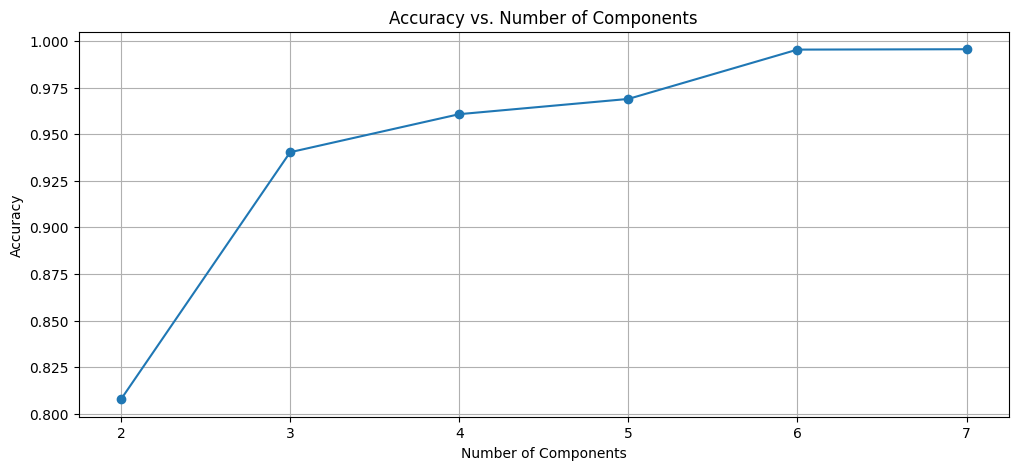

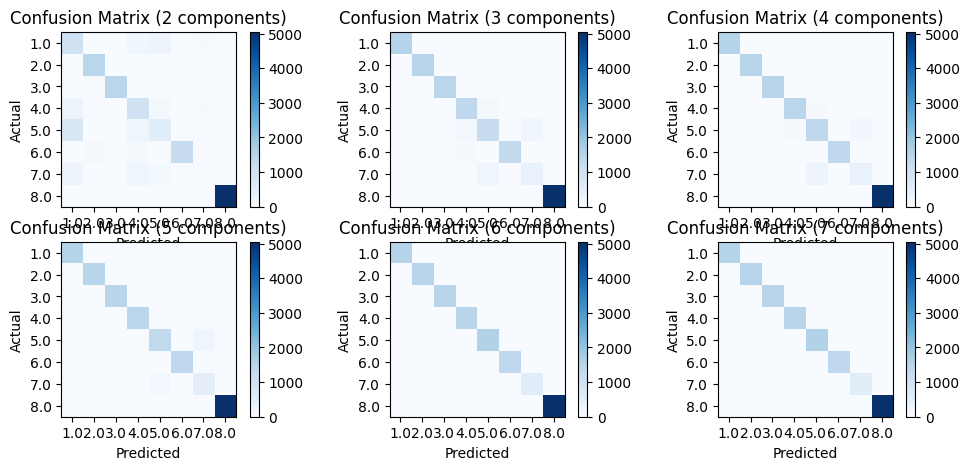

In [ ]:
# Plot the accuracy results
plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
plt.plot(components_range, accuracy_results, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xticks(components_range)
plt.grid(True)
plt.show()

# Plot confusion matrices (one for each number of components)
plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
for i, n_components in enumerate(components_range):
    plt.subplot(2, 3, i + 1)
    plt.imshow(confusion_matrix_results[i], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({n_components} components)')
    plt.colorbar()
    plt.xticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
    plt.yticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

# plt.tight_layout()
plt.show()

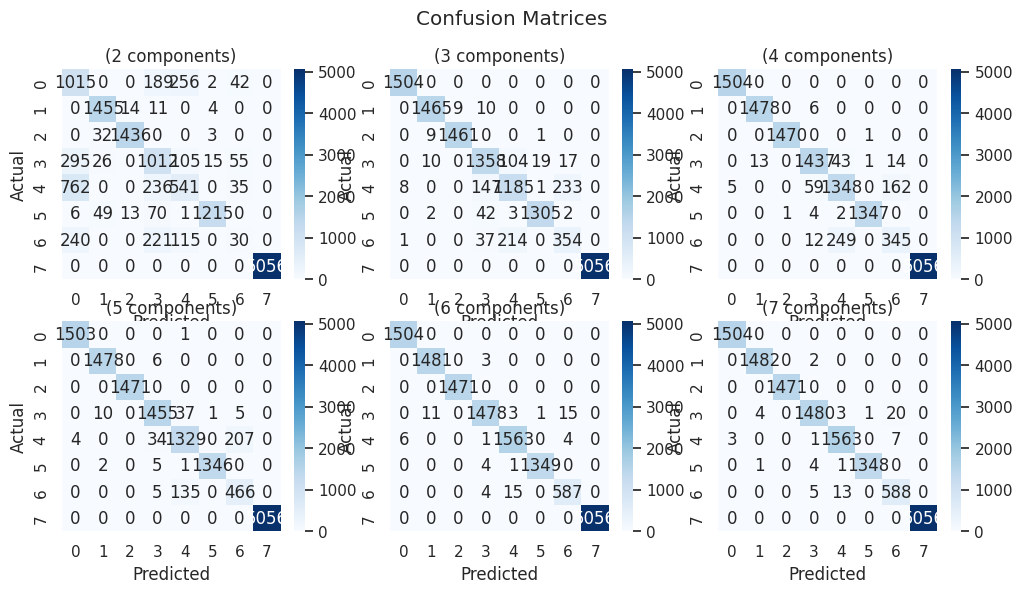

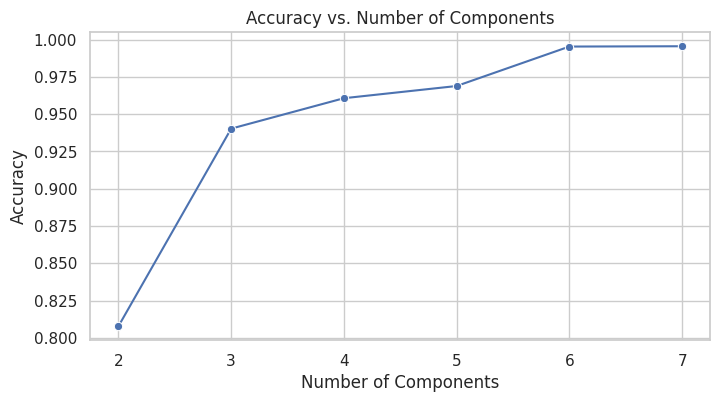

In [ ]:
# Select every 150 points from the dataset
selected_indices = range(0, len(normalized_spectra_wo_nan), 150)
selected_data = normalized_spectra_wo_nan[selected_indices]
selected_labels = label_mask_wo_nan[selected_indices]

# Set Seaborn style
sns.set(style="whitegrid")

# Create a grid of subplots for confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('Confusion Matrices')

for i, n_components in enumerate(components_range):
    ax = axes[i // 3, i % 3]
    sns.heatmap(confusion_matrix_results[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f'({n_components} components)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Separate figure for the accuracy plot
plt.figure(figsize=(8, 4))
sns.lineplot(x=components_range, y=accuracy_results, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xticks(components_range)
plt.grid(True)

plt.show()

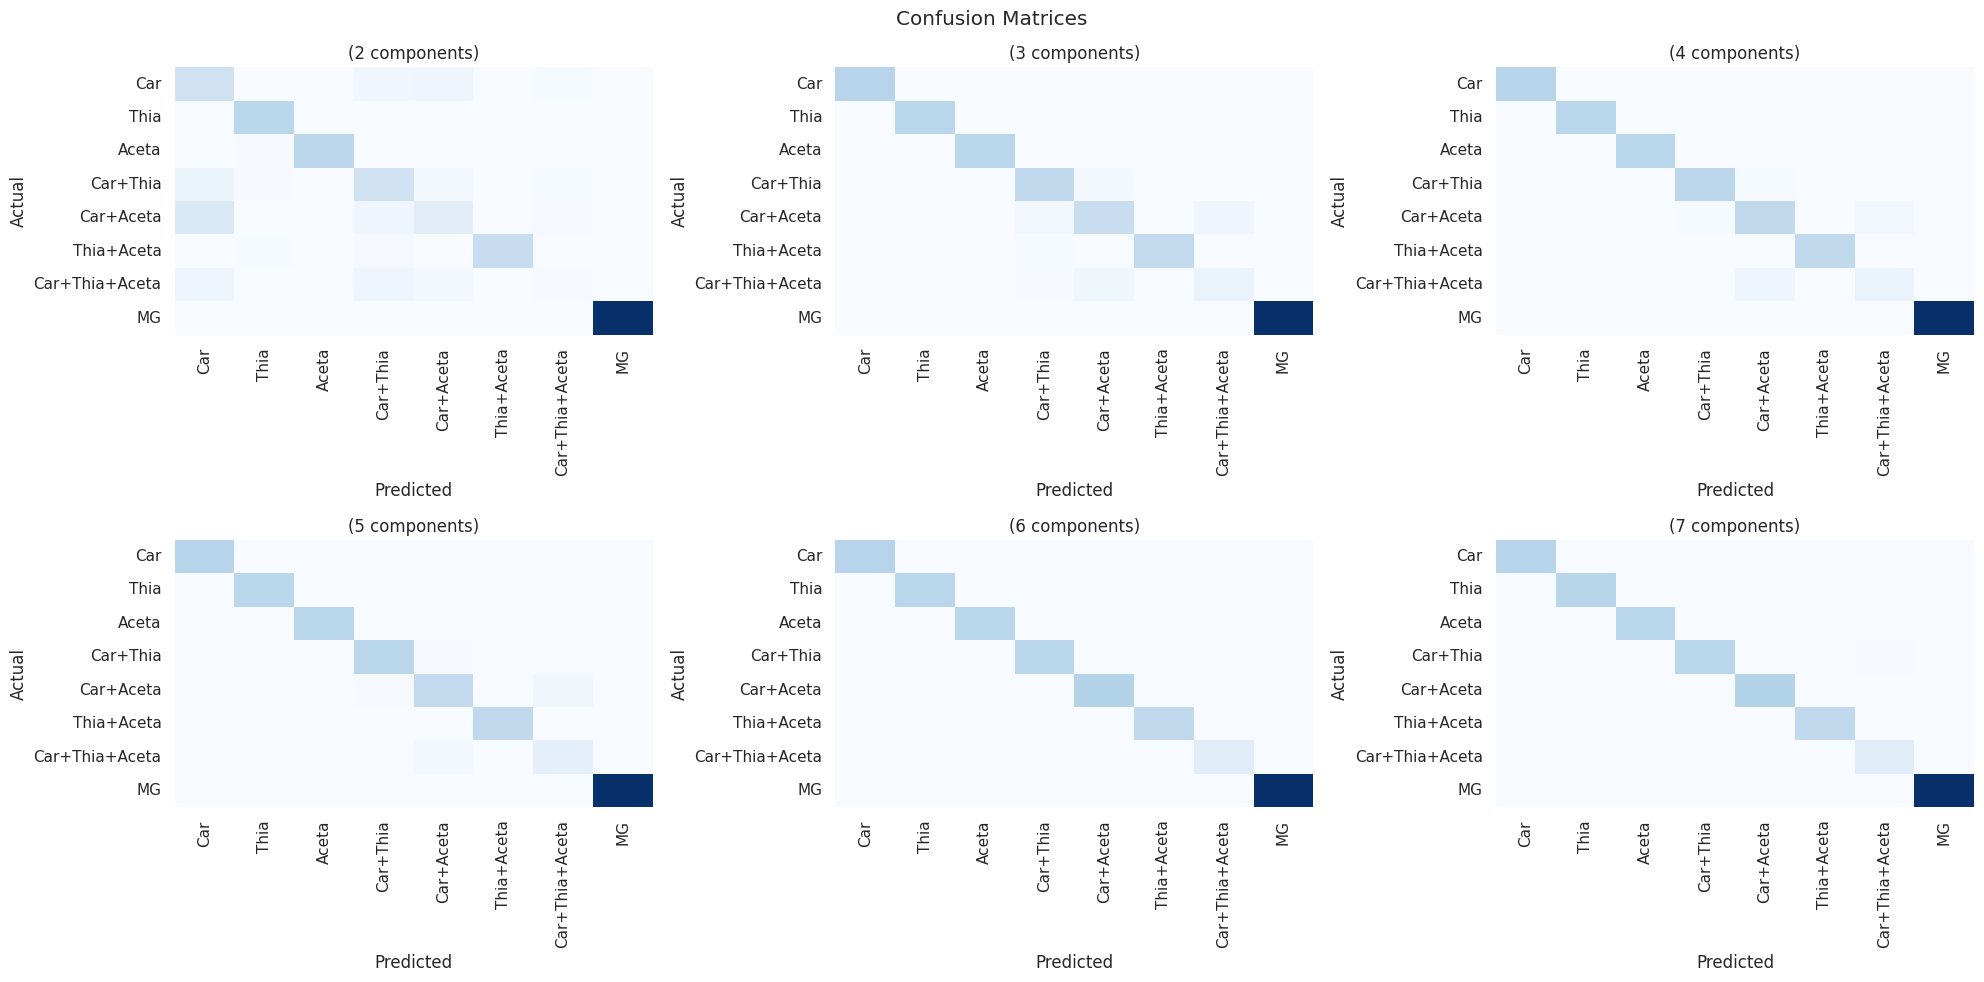

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")
labels = ["Car", "Thia", "Aceta", "Car+Thia", "Car+Aceta", "Thia+Aceta", "Car+Thia+Aceta", "MG"]

# Create a grid of subplots for confusion matrices with more space
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Confusion Matrices')

for i, n_components in enumerate(components_range):
    ax = axes[i // 3, i % 3]

    # Create a confusion matrix heatmap with class labels
    sns.heatmap(confusion_matrix_results[i], annot=False, cmap="Blues", ax=ax, cbar=False, xticklabels=labels, yticklabels=labels)

    ax.set_title(f'({n_components} components)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Rotate class labels perpendicularly to the box
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## SVM

In [ ]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Step 3: Feature Selection or Dimensionality Reduction (if needed)

# Step 4: Model Selection - Choose the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # Example with an RBF kernel

# Step 5: Model Training
svm_model.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.999793913581095


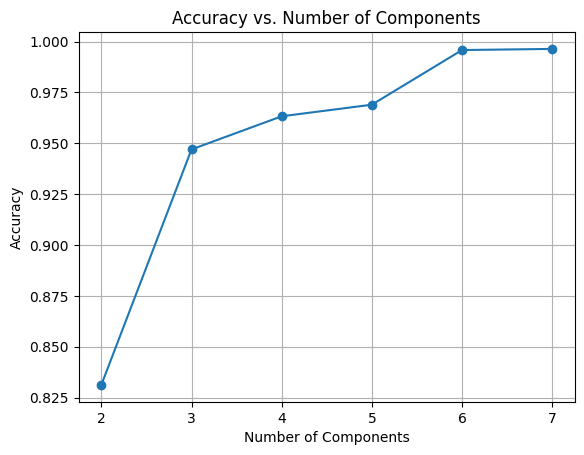

In [ ]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: SVM Model Selection
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # Example with an RBF kernel

    # Step 5: Create a Pipeline
    # Combine PCA and SVM into a single pipeline
    model = Pipeline([('pca', pca), ('svm', svm_model)])

    # Step 7: Model Training
    model.fit(X_train, y_train)

    # Step 6: Model Evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
accuracy_table.append(accuracy_values)

## Naive Bayes

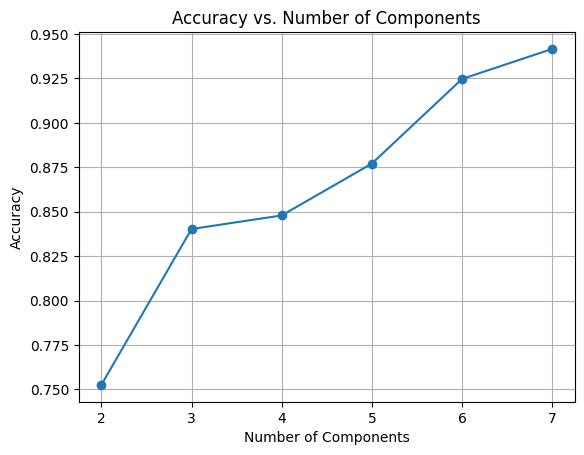

In [ ]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: Naive Bayes Model Selection (Gaussian Naive Bayes)
    nb_model = GaussianNB()

    # Step 5: Create a Pipeline
    # Combine PCA and Naive Bayes into a single pipeline
    model = Pipeline([('pca', pca), ('nb', nb_model)])

    # Step 7: Model Training
    model.fit(X_train, y_train)

    # Step 6: Model Evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
accuracy_table.append(accuracy_values)

## Random Forest

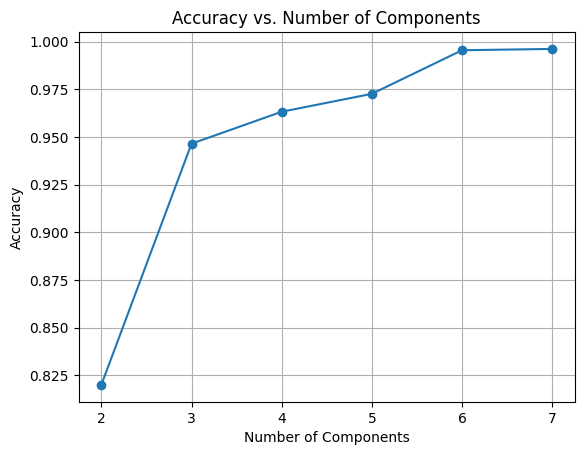

In [ ]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: Random Forest Model Selection
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Step 7: Model Training
    # Apply PCA and then train the Random Forest model
    X_train_pca = pca.fit_transform(X_train)
    rf_model.fit(X_train_pca, y_train)

    # Step 6: Model Evaluation
    X_test_pca = pca.transform(X_test)
    y_pred = rf_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
accuracy_table.append(accuracy_values)

In [ ]:
import csv
import copy

In [ ]:
def take_two_digits_after_decimal_point_without_rounding(number):
    """Takes two digits after the decimal point without rounding.

    Args:
      number: A float number.

    Returns:
      A float number with two digits after the decimal point.
    """

    string_representation = str(number)
    decimal_point_index = string_representation.find('.')
    two_digits_after_decimal_point = string_representation[decimal_point_index + 1:decimal_point_index + 3]
    return float(two_digits_after_decimal_point)

In [ ]:
def take_two_digits_after_decimal_point_without_rounding_list_of_lists(list_of_lists):
  """Takes two digits after the decimal point without rounding for a list of lists.

  Args:
    list_of_lists: A list of lists containing float numbers.

  Returns:
    A list of lists with two digits after the decimal point for each element.
  """

  for i in range(len(list_of_lists)):
    for j in range(len(list_of_lists[i])):
      list_of_lists[i][j] = take_two_digits_after_decimal_point_without_rounding(list_of_lists[i][j])
  return list_of_lists

In [ ]:
copied_accuracy_table = copy.deepcopy(accuracy_table)
new_list_of_lists = take_two_digits_after_decimal_point_without_rounding_list_of_lists(copied_accuracy_table)

In [ ]:
rounded_acc_values = np.around(accuracy_table, 2)

In [ ]:
decimal_acc_values = [[x * 100 for x in y] for y in new_list_of_lists]

In [ ]:
new_list_of_lists

[[80.0, 94.0, 96.0, 96.0, 99.0, 99.0],
 [83.0, 94.0, 96.0, 96.0, 99.0, 99.0],
 [75.0, 84.0, 84.0, 87.0, 92.0, 94.0],
 [81.0, 94.0, 96.0, 97.0, 99.0, 99.0]]

In [ ]:
with open('accuracy_table_rounded_decimal.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)

    # Write the sublists to the CSV file using the writerow() method
    for row in new_list_of_lists:
        writer.writerow(row)

# Close the CSV file
csvfile.close()

## Multilabel multioutput classification

In [14]:
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

In [15]:
# Create a multi-label classifier
classifier = MultiOutputClassifier(KNeighborsClassifier())

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

In [ ]:
csv_file_path = "y_pred.csv"

# Save y_pred to a CSV file
np.savetxt(csv_file_path, y_pred, delimiter=",")

In [ ]:
y_pred_loaded = np.genfromtxt("y_pred.csv", delimiter=',')

In [ ]:
y_pred = np.copy(y_pred_loaded)

In [16]:
# Calculate accuracy and Hamming loss
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)
j_score = jaccard_score(y_test, y_pred, average='samples')

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)
print(f'Jaccard Score: {j_score}')

Accuracy: 0.9984200041217284
Hamming Loss: 0.0004636944425362369
Jaccard Score: 0.9993244945158115


In [19]:
# Create a custom confusion matrix
unique_labels = np.unique(class_labels)
confusion_matrix = np.zeros((len(unique_labels) + 1, len(unique_labels) + 1), dtype=int)

for i, true_label in enumerate(y_test):
    for j, pred_label in enumerate(y_pred):
        for k, label in enumerate(unique_labels):
            if true_label[k] == 1 and pred_label[k] == 1:
                # True positive
                confusion_matrix[k, k] += 1
            elif true_label[k] == 1 and pred_label[k] == 0:
                # False negative
                confusion_matrix[k, -1] += 1
            elif true_label[k] == 0 and pred_label[k] == 1:
                # False positive
                confusion_matrix[-1, k] += 1

# Print the custom confusion matrix
print("Custom Confusion Matrix:")
print(confusion_matrix)

KeyboardInterrupt: 

In [20]:
print(multilabel_confusion_matrix(y_test, y_pred))

[[[9363    2]
  [   1 5191]]

 [[9593   12]
  [   4 4948]]

 [[9550    2]
  [   6 4999]]

 [[9501    0]
  [   0 5056]]]


# Deep Learning

## PyTorch

In [ ]:
device = torch.device("cuda")

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

In [ ]:
dataset_tensor = torch.tensor(normalized_spectra_wo_nan, dtype=torch.long)
labels_tensor = torch.tensor(label_mask_wo_nan, dtype=torch.long)

### Splitting the dataset

In [ ]:
# Determine the sizes of your train, validation, and test sets
train_size = 0.6
val_size = 0.2
test_size = 0.2

# Define number of workers for GPU
num_workers = 2

# Step 1: Split the dataset into train and temp sets
data_train, data_temp, labels_train, labels_temp = train_test_split(dataset_tensor, labels_tensor, test_size=(1 - train_size))

# Step 2: Split the temp set into validation and test sets
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=test_size / (test_size + val_size))

# Step 3: Create datasets and data loaders
train_dataset = TensorDataset(data_train, labels_train)
val_dataset = TensorDataset(data_val, labels_val)
test_dataset = TensorDataset(data_test, labels_test)

# Define data loaders for train, validation, and test sets
batch_size = 256  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
class ModelC2(torch.nn.Module):
    def __init__(self):
        super(ModelC2, self).__init__()

        self.dense1 = torch.nn.Linear(1600, 8)
        self.dense2 = torch.nn.Linear(8, 8)
        self.dense3 = torch.nn.Linear(8, 10)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.softmax(self.dense3(x))
        return x

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, encoder_outputs):
        energy = torch.tanh(self.attn(encoder_outputs))
        attention = torch.nn.functional.softmax(self.v(energy), dim=0)
        context = torch.sum(attention * encoder_outputs, dim=0)
        return context

class ModelC2WithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ModelC2WithAttention, self).__init__()
        self.dense1 = torch.nn.Linear(input_dim, hidden_dim)
        self.dense2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)
        self.attention = Attention(hidden_dim)

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.dense3(x)
        x = self.softmax(x)

        # Apply attention mechanism to the output of dense3
        context = self.attention(x)

        return context


In [ ]:
# Initialize your model
model = ModelC2()
model = model.to(device)  # Moves the model to GPU

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 100

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

In [ ]:
model_with_attention = ModelC2WithAttention(input_dim=1600, hidden_dim=16, output_dim=8)

In [ ]:
# Check if the model is on the GPU
if next(model.parameters()).is_cuda:
    print("Model is on GPU")
else:
    print("Model is on CPU")

# # Check if your tensors are on the GPU (e.g., inputs and labels)
# if inputs.is_cuda:
#     print("Inputs are on GPU")
# else:
#     print("Inputs are on CPU")

# if labels.is_cuda:
#     print("Labels are on GPU")
# else:
#     print("Labels are on CPU")

Model is on GPU


In [ ]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics for the epoch
    train_losses.append(loss.item())
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = (100 * correct / total)
    val_accuracies.append(val_accuracy)


    # Print the training and validation statistics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {loss.item():.4f} - Validation Loss: {val_loss/len(val_loader):.4f} - Validation Accuracy: {(100 * correct / total):.2f}%")

print("Training finished.")

Epoch 1/100 - Training Loss: 2.2700 - Validation Loss: 2.2680 - Validation Accuracy: 34.42%
Epoch 2/100 - Training Loss: 2.0084 - Validation Loss: 1.9948 - Validation Accuracy: 42.99%
Epoch 3/100 - Training Loss: 1.9679 - Validation Loss: 1.9525 - Validation Accuracy: 48.96%
Epoch 4/100 - Training Loss: 1.8987 - Validation Loss: 1.8860 - Validation Accuracy: 57.93%
Epoch 5/100 - Training Loss: 1.8867 - Validation Loss: 1.8717 - Validation Accuracy: 57.90%
Epoch 6/100 - Training Loss: 1.8777 - Validation Loss: 1.8622 - Validation Accuracy: 61.66%
Epoch 7/100 - Training Loss: 1.8641 - Validation Loss: 1.8477 - Validation Accuracy: 61.64%
Epoch 8/100 - Training Loss: 1.8626 - Validation Loss: 1.8414 - Validation Accuracy: 61.64%
Epoch 9/100 - Training Loss: 1.8619 - Validation Loss: 1.8393 - Validation Accuracy: 61.70%
Epoch 10/100 - Training Loss: 1.8549 - Validation Loss: 1.8379 - Validation Accuracy: 61.82%
Epoch 11/100 - Training Loss: 1.8591 - Validation Loss: 1.8374 - Validation Acc

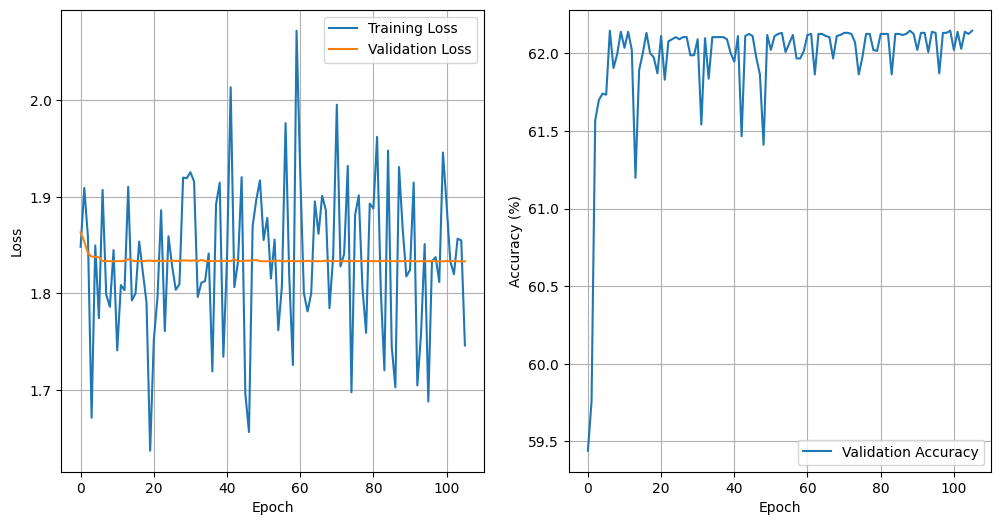

In [ ]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
model_c2 = ModelC2()

# Load the trained model
# model_c2.load_state_dict(torch.load('model.pt'))

# Make a prediction on a new data point
new_data = torch.randn(1024)
prediction = model_c2(new_data)

# Get the class with the highest probability
predicted_class = torch.argmax(prediction)

# Print the predicted class
print(predicted_class)

## Tensorflow


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, Bidirectional, RepeatVector, Permute, Multiply, Input
from keras.utils import to_categorical

### Label Mask for 7 classes

In [10]:
label_mask = np.zeros((47740))

label_mask[0:7500] = 0
label_mask[7500:15000] = 1
label_mask[15000:22500] = 2
label_mask[22500:30000] = 3
label_mask[30000:37500] = 4
label_mask[37500:44668] = 5
label_mask[44668:47740] = 6

### Individual classes label mask

In [11]:
# Carbendazim mask
label_mask = np.zeros((47740))

label_mask[0:7500] = 1
label_mask[7500:15000] = 0
label_mask[15000:22500] = 0
label_mask[22500:30000] = 0
label_mask[30000:37500] = 0
label_mask[37500:44668] = 0
label_mask[44668:47740] = 0

In [10]:
# Thiacloprid mask
label_mask = np.zeros((47740))

label_mask[0:7500] = 0
label_mask[7500:15000] = 1
label_mask[15000:22500] = 0
label_mask[22500:30000] = 0
label_mask[30000:37500] = 0
label_mask[37500:44668] = 0
label_mask[44668:47740] = 0

In [10]:
# Acetamiprid mask
label_mask = np.zeros((47740))

label_mask[0:7500] = 0
label_mask[7500:15000] = 0
label_mask[15000:22500] = 1
label_mask[22500:30000] = 0
label_mask[30000:37500] = 0
label_mask[37500:44668] = 0
label_mask[44668:47740] = 0

### Label Mask for 2 classes

In [40]:
spectra_dataset_2_classes = np.copy(spectra_dataset[:15000])

In [41]:
label_mask_2_classes = np.zeros((15000))

label_mask_2_classes[0:7500] = 0
label_mask_2_classes[7500:15000] = 1

### Lable mask for 3 classes

In [42]:
spectra_dataset_3_classes = np.copy(spectra_dataset[:22500])

In [43]:
label_mask_3_classes = np.zeros((22500))

label_mask_3_classes[0:7500] = 0
label_mask_3_classes[7500:15000] = 1
label_mask_3_classes[15000:22500] = 2

### Lable mask for 4 classes

In [44]:
spectra_dataset_4_classes = np.copy(spectra_dataset[:30000])

In [45]:
label_mask_4_classes = np.zeros((30000))

label_mask_4_classes[0:7500] = 0
label_mask_4_classes[7500:15000] = 1
label_mask_4_classes[15000:22500] = 2
label_mask_4_classes[22500:30000] = 3

### Label mask for 5 classes

In [46]:
spectra_dataset_5_classes = np.copy(spectra_dataset[:37500])

In [47]:
label_mask_5_classes = np.zeros((37500))

label_mask_5_classes[0:7500] = 0
label_mask_5_classes[7500:15000] = 1
label_mask_5_classes[15000:22500] = 2
label_mask_5_classes[22500:30000] = 3
label_mask_5_classes[30000:37500] = 4

### Data Preprocessing

In [11]:
spectra_dataset_wo_mg = np.copy(spectra_dataset[:47740])

max_values = np.max(spectra_dataset_wo_mg, axis=1)  # Get the maximum value for each spectrum
normalized_spectra = spectra_dataset_wo_mg / max_values[:, np.newaxis]  # Divide each spectrum by its maximum value
normalized_spectra_wo_nan = normalized_spectra[~np.isnan(normalized_spectra).any(axis=1)] # Remove the values with the same index from the dataset

# Remove the values with the same index from the label mask
label_mask_wo_nan = label_mask[~np.isnan(normalized_spectra).any(axis=1)]

/tmp/ipykernel_54366/3287897683.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_spectra = spectra_dataset_wo_mg / max_values[:, np.newaxis]  # Divide each spectrum by its maximum value


#### Preprocessing for subset of classes

### Splitting the dataset

In [12]:
train_size = 0.6
val_size = 0.2
test_size = 0.2

In [13]:
# For the whole dataset
data_train, data_temp, labels_train, labels_temp = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=(1 - train_size))

# Step 2: Split the temp set into validation and test sets
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=test_size / (test_size + val_size))

In [14]:
# For 2 classes
data_train_2_classes, data_temp_2_classes, labels_train_2_classes, labels_temp_2_classes = train_test_split(normalized_spectra_2_classes_wo_nan, label_mask_2_classes_wo_nan, test_size=(1 - train_size))
data_val_2_classes, data_test_2_classes, labels_val_2_classes, labels_test_2_classes = train_test_split(data_temp_2_classes, labels_temp_2_classes, test_size=test_size / (test_size + val_size))

NameError: name 'normalized_spectra_2_classes_wo_nan' is not defined

In [52]:
# For 3 classes
data_train_3_classes, data_temp_3_classes, labels_train_3_classes, labels_temp_3_classes = train_test_split(normalized_spectra_3_classes_wo_nan, label_mask_3_classes_wo_nan, test_size=(1 - train_size))
data_val_3_classes, data_test_3_classes, labels_val_3_classes, labels_test_3_classes = train_test_split(data_temp_3_classes, labels_temp_3_classes, test_size=test_size / (test_size + val_size))

In [53]:
# For 4 classes
data_train_4_classes, data_temp_4_classes, labels_train_4_classes, labels_temp_4_classes = train_test_split(normalized_spectra_4_classes_wo_nan, label_mask_4_classes_wo_nan, test_size=(1 - train_size))
data_val_4_classes, data_test_4_classes, labels_val_4_classes, labels_test_4_classes = train_test_split(data_temp_4_classes, labels_temp_4_classes, test_size=test_size / (test_size + val_size))

In [54]:
# For 5 classes
data_train_5_classes, data_temp_5_classes, labels_train_5_classes, labels_temp_5_classes = train_test_split(normalized_spectra_5_classes_wo_nan, label_mask_5_classes_wo_nan, test_size=(1 - train_size))
data_val_5_classes, data_test_5_classes, labels_val_5_classes, labels_test_5_classes = train_test_split(data_temp_5_classes, labels_temp_5_classes, test_size=test_size / (test_size + val_size))

### One-hot encoding

In [ ]:
labels_train_one_hot = to_categorical(labels_train, num_classes=7)
labels_val_one_hot = to_categorical(labels_val, num_classes=7)
labels_test_one_hot = to_categorical(labels_test, num_classes=7)

In [14]:
labels_train_one_hot = to_categorical(labels_train, num_classes=2)
labels_val_one_hot = to_categorical(labels_val, num_classes=2)
labels_test_one_hot = to_categorical(labels_test, num_classes=2)

In [15]:
labels_train_one_hot[np.where(labels_train_one_hot == [0, 1])]

array([0., 1., 0., ..., 1., 0., 1.], dtype=float32)

In [56]:
# For 2 classes
labels_train_2_classes_one_hot = to_categorical(labels_train_2_classes, num_classes=2)
labels_val_2_classes_one_hot = to_categorical(labels_val_2_classes, num_classes=2)
labels_test_2_classes_one_hot = to_categorical(labels_test_2_classes, num_classes=2)

In [57]:
# For 3 classes
labels_train_3_classes_one_hot = to_categorical(labels_train_3_classes, num_classes=3)
labels_val_3_classes_one_hot = to_categorical(labels_val_3_classes, num_classes=3)
labels_test_3_classes_one_hot = to_categorical(labels_test_3_classes, num_classes=3)

In [58]:
# For 4 classes
labels_train_4_classes_one_hot = to_categorical(labels_train_4_classes, num_classes=4)
labels_val_4_classes_one_hot = to_categorical(labels_val_4_classes, num_classes=4)
labels_test_4_classes_one_hot = to_categorical(labels_test_4_classes, num_classes=4)

In [59]:
# For 5 classes
labels_train_5_classes_one_hot = to_categorical(labels_train_5_classes, num_classes=5)
labels_val_5_classes_one_hot = to_categorical(labels_val_5_classes, num_classes=5)
labels_test_5_classes_one_hot = to_categorical(labels_test_5_classes, num_classes=5)

### DNN

In [16]:
model_c2 = Sequential()
model_c2.add(Dense(12, input_dim=1600, activation='relu'))
model_c2.add(Dense(8, activation='relu'))
model_c2.add(Dense(7, activation='softmax'))
model_c2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_accuracy'])

2024-01-24 11:58:49.185863: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 11:58:49.359695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 11:58:49.359936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
history_dnn = model_c2.fit(data_train, labels_train_one_hot, epochs=10, batch_size=256, validation_data=(data_val, labels_val_one_hot))

Epoch 1/10


2024-01-24 11:59:23.302848: I external/local_xla/xla/service/service.cc:168] XLA service 0x556a43fd0390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 11:59:23.302875: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-01-24 11:59:23.315363: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-24 11:59:23.342940: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1706068763.417564   74998 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


111/111 [==============================] - 2s 5ms/step - loss: 1.6106 - categorical_accuracy: 0.2888 - val_loss: 1.3206 - val_categorical_accuracy: 0.4215
Epoch 2/10
111/111 [==============================] - 0s 3ms/step - loss: 1.0847 - categorical_accuracy: 0.5746 - val_loss: 0.8506 - val_categorical_accuracy: 0.7133
Epoch 3/10
111/111 [==============================] - 0s 3ms/step - loss: 0.6409 - categorical_accuracy: 0.7555 - val_loss: 0.4750 - val_categorical_accuracy: 0.8092
Epoch 4/10
111/111 [==============================] - 0s 3ms/step - loss: 0.3374 - categorical_accuracy: 0.9261 - val_loss: 0.2278 - val_categorical_accuracy: 0.9429
Epoch 5/10
111/111 [==============================] - 0s 3ms/step - loss: 0.1794 - categorical_accuracy: 0.9594 - val_loss: 0.1569 - val_categorical_accuracy: 0.9565
Epoch 6/10
111/111 [==============================] - 0s 3ms/step - loss: 0.1268 - categorical_accuracy: 0.9761 - val_loss: 0.1135 - val_categorical_accuracy: 0.9839
Epoch 7/10
111/

In [18]:
results_dnn = model_c2.evaluate(data_test, labels_test_one_hot, batch_size=128)

74/74 [==============================] - 0s 2ms/step - loss: 0.0542 - categorical_accuracy: 0.9922


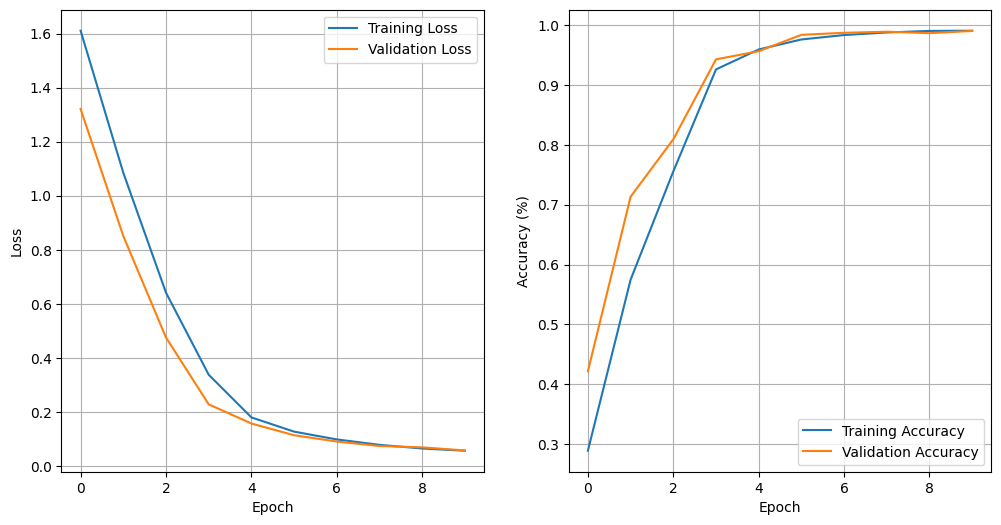

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
history3 = model.fit(data_train, labels_train_one_hot, epochs=10, batch_size=32)

Epoch 1/10


ValueError: in user code:

    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_1' (type Functional).
    
    Input 0 of layer "permute_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'model_1' (type Functional):
      • inputs=tf.Tensor(shape=(None, 1600), dtype=float32)
      • training=True
      • mask=None


### CNN

In [21]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [22]:
# CNN model
model_c2 = Sequential()
model_c2.add(Conv1D(32, 3, activation='relu', input_shape=(1600, 1)))
model_c2.add(MaxPooling1D(2))
model_c2.add(Conv1D(64, 3, activation='relu'))
model_c2.add(MaxPooling1D(2))
model_c2.add(Flatten())
model_c2.add(Dense(12, activation='relu'))
model_c2.add(Dense(8, activation='relu'))
model_c2.add(Dense(7, activation='softmax'))
model_c2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [26]:
model_c2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1598, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 799, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 797, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 398, 64)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 25472)             0         
                                                                 
 dense_6 (Dense)             (None, 12)               

In [23]:
history2 = model_c2.fit(data_train, labels_train_one_hot, epochs=10, batch_size=256, validation_data=(data_val, labels_val_one_hot))

Epoch 1/10
111/111 [==============================] - 5s 24ms/step - loss: 1.1679 - categorical_accuracy: 0.5995 - val_loss: 0.5404 - val_categorical_accuracy: 0.7669
Epoch 2/10
111/111 [==============================] - 2s 14ms/step - loss: 0.3583 - categorical_accuracy: 0.8372 - val_loss: 0.1917 - val_categorical_accuracy: 0.9583
Epoch 3/10
111/111 [==============================] - 2s 14ms/step - loss: 0.1435 - categorical_accuracy: 0.9666 - val_loss: 0.0924 - val_categorical_accuracy: 0.9830
Epoch 4/10
111/111 [==============================] - 2s 14ms/step - loss: 0.0857 - categorical_accuracy: 0.9799 - val_loss: 0.0616 - val_categorical_accuracy: 0.9868
Epoch 5/10
111/111 [==============================] - 2s 14ms/step - loss: 0.0678 - categorical_accuracy: 0.9823 - val_loss: 0.0561 - val_categorical_accuracy: 0.9844
Epoch 6/10
111/111 [==============================] - 2s 14ms/step - loss: 0.0502 - categorical_accuracy: 0.9883 - val_loss: 0.0391 - val_categorical_accuracy: 0.990

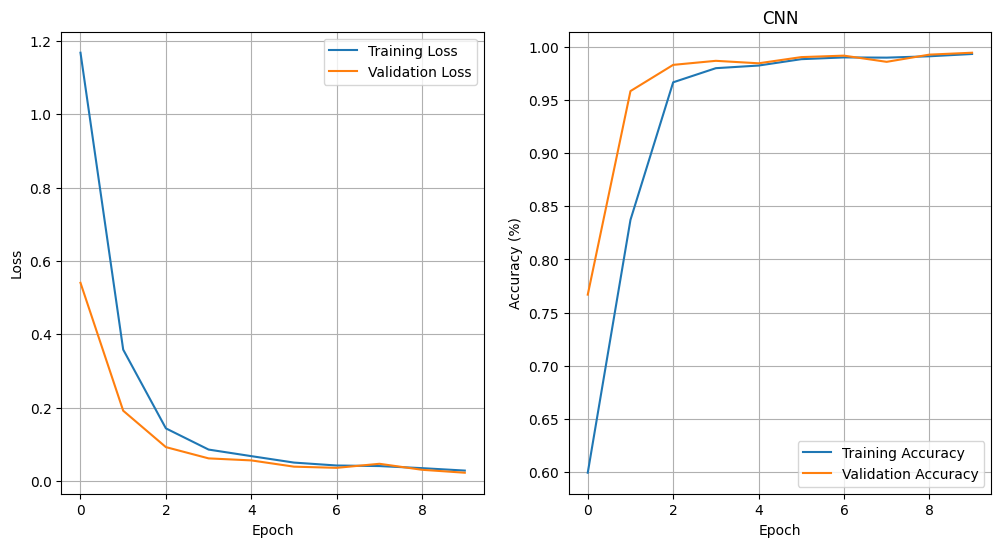

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history2.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.title('CNN')
plt.show()

### LSTM

In [27]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model_lstm = Sequential()
model_lstm.add(LSTM(12, input_shape=(1600, 1), return_sequences=True))
model_lstm.add(LSTM(8, return_sequences=False))
model_lstm.add(Dense(7, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_accuracy'])

In [28]:
history_lstm = model_lstm.fit(data_train, labels_train_one_hot, epochs=50, batch_size=256, validation_data=(data_val, labels_val_one_hot))

Epoch 1/50
111/111 [==============================] - 11s 76ms/step - loss: 1.9155 - categorical_accuracy: 0.1677 - val_loss: 1.8520 - val_categorical_accuracy: 0.2786
Epoch 2/50
111/111 [==============================] - 8s 70ms/step - loss: 1.7792 - categorical_accuracy: 0.2864 - val_loss: 1.6945 - val_categorical_accuracy: 0.3417
Epoch 3/50
111/111 [==============================] - 8s 70ms/step - loss: 1.6649 - categorical_accuracy: 0.3403 - val_loss: 1.6122 - val_categorical_accuracy: 0.3457
Epoch 4/50
111/111 [==============================] - 8s 71ms/step - loss: 1.5367 - categorical_accuracy: 0.3632 - val_loss: 1.3998 - val_categorical_accuracy: 0.4014
Epoch 5/50
111/111 [==============================] - 8s 74ms/step - loss: 1.3839 - categorical_accuracy: 0.3839 - val_loss: 1.3829 - val_categorical_accuracy: 0.3657
Epoch 6/50
111/111 [==============================] - 8s 71ms/step - loss: 1.3419 - categorical_accuracy: 0.4019 - val_loss: 1.3081 - val_categorical_accuracy: 0.43

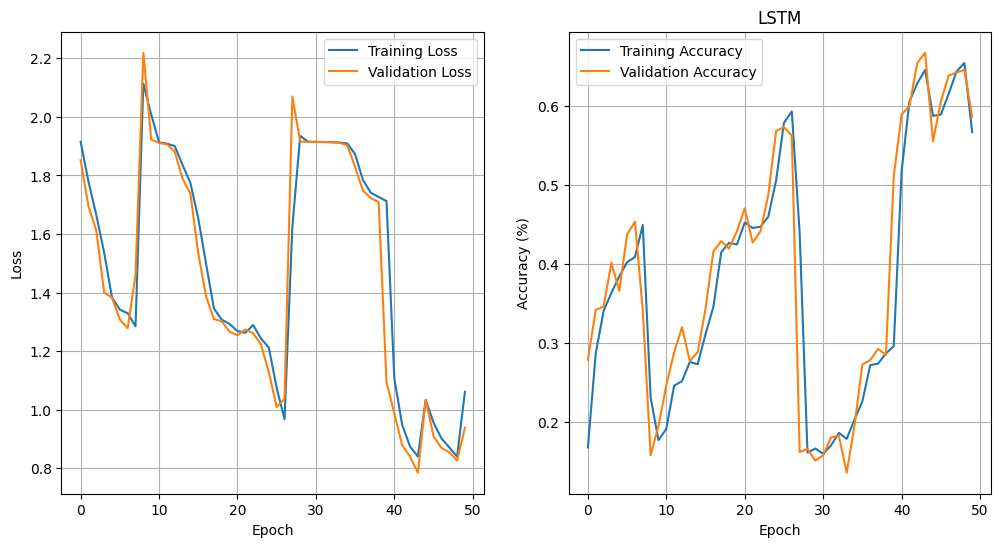

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.title('LSTM')
plt.show()

### ATTENTION

In [17]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Multiply
from keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation
from keras import backend as K

In [32]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    a = Permute((2, 1))(inputs)
    a = Dense(1600, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    return Multiply()([inputs, a_probs])

In [33]:
inputs = Input(shape=(1600, 1))
attention_mul = attention_3d_block(inputs)
attention_mul = LSTM(12, return_sequences=False)(attention_mul)
output = Dense(7, activation='softmax')(attention_mul)
model = Model(inputs=[inputs], outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# To visualize the attention weights
attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_vec').output)

In [34]:
model.fit(data_train, labels_train_one_hot, epochs=20, batch_size=256, validation_data=(data_val, labels_val_one_hot))

Epoch 1/20
111/111 [==============================] - 6s 43ms/step - loss: 1.9277 - categorical_accuracy: 0.1575 - val_loss: 1.9164 - val_categorical_accuracy: 0.1561
Epoch 2/20
111/111 [==============================] - 4s 39ms/step - loss: 1.9156 - categorical_accuracy: 0.1601 - val_loss: 1.9149 - val_categorical_accuracy: 0.1577
Epoch 3/20
111/111 [==============================] - 4s 39ms/step - loss: 1.9092 - categorical_accuracy: 0.2006 - val_loss: 1.9025 - val_categorical_accuracy: 0.1595
Epoch 4/20
111/111 [==============================] - 4s 40ms/step - loss: 1.8824 - categorical_accuracy: 0.2287 - val_loss: 1.8565 - val_categorical_accuracy: 0.4119
Epoch 5/20
111/111 [==============================] - 4s 40ms/step - loss: 1.8231 - categorical_accuracy: 0.3581 - val_loss: 1.7872 - val_categorical_accuracy: 0.3681
Epoch 6/20
111/111 [==============================] - 4s 39ms/step - loss: 2.0449 - categorical_accuracy: 0.2050 - val_loss: 1.9231 - val_categorical_accuracy: 0.162

296/296 [==============================] - 0s 906us/step


<Figure size 1000x2000 with 0 Axes>

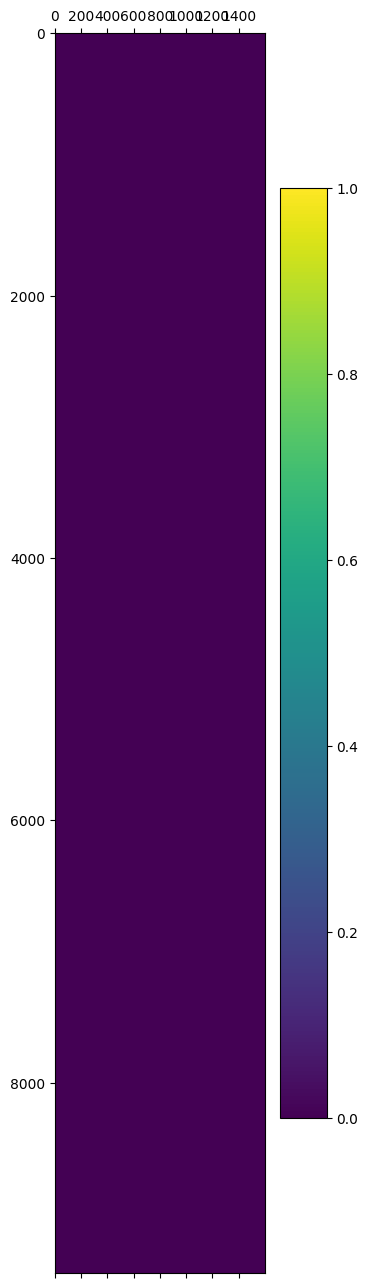

In [37]:
# Assuming you have some data in `data`
# data = ...

attention_vector = attention_model.predict(data_test)
plt.figure(figsize=(10, 20))
plt.matshow(attention_vector)
plt.colorbar()
plt.show()

In [18]:
def attention(input_sequence):
    attention_weights = Dense(1, activation='tanh')(input_sequence)
    # attention_weights = Flatten()(attention_weights)
    attention_weights = Activation('softmax')(attention_weights)
    # attention_weights = RepeatVector(sequence_length)(attention_weights)
    attention_weights = Permute([2, 1])(attention_weights)
    return attention_weights
# Define your network architecture
def create_attention_network(sequence_length, input_dim, hidden_units):
    input_sequence = Input(shape=(sequence_length, input_dim))
    # Apply attention mechanism
    attention_weights = attention(input_sequence)
    attention_weights_expanded = tf.expand_dims(attention_weights, axis=-1)  # Expand dimensions for broadcasting
    weighted_sequence = Multiply()([input_sequence, attention_weights_expanded])
    # Reshape the input to match the LSTM input shape
    reshaped_sequence = tf.reshape(weighted_sequence, (-1, sequence_length, input_dim))
    # Add more layers as per your network architecture
    hidden_layer = Bidirectional(LSTM(hidden_units, return_sequences=False))(reshaped_sequence)
    output = Dense(7)(hidden_layer)  # Output layer with 1 unit for regression
    return Model(inputs=input_sequence, outputs=output)

In [19]:
model = create_attention_network(sequence_length=200, input_dim=1600, hidden_units=64)
model.compile(optimizer='adam', loss='mean_squared_error')

2024-01-24 13:02:59.176088: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-24 13:02:59.176120: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: anvar-ASUS-TUF-Gaming-A15-FA506QR-FA506QR
2024-01-24 13:02:59.176128: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: anvar-ASUS-TUF-Gaming-A15-FA506QR-FA506QR
2024-01-24 13:02:59.176386: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.154.5
2024-01-24 13:02:59.176407: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-01-24 13:02:59.176413: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.154.5


In [21]:
history_attention = model.fit(data_train, labels_train_one_hot, epochs=10, batch_size=200, validation_data=(data_val, labels_val_one_hot))

Epoch 1/10


ValueError: in user code:

    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 200, 1600), found shape=(None, 1600)


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

In [27]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")        
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et=tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x,self.W)+self.b), axis=-1)
        et = tf.keras.backend.expand_dims(et, axis=-1)
        at=tf.keras.backend.softmax(et)
        at=tf.keras.backend.expand_dims(at, axis=-1)
        output=x*at
        return tf.keras.backend.expand_dims(tf.keras.backend.sum(output, axis=1), axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(AttentionLayer,self).get_config()

In [18]:
data_train.shape

(28356, 1600)

In [28]:
inputs = tf.keras.Input(shape=(1600,))
attention_output = AttentionLayer()(inputs)
outputs = Dense(7, activation='sigmoid')(attention_output)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assume X_train and y_train are your data
model.fit(data_train, labels_train_one_hot, epochs=10, batch_size=32)

Epoch 1/10


2024-01-25 17:17:09.291059: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 181478400 exceeds 10% of free system memory.
2024-01-25 17:17:09.494929: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 181478400 exceeds 10% of free system memory.


ValueError: in user code:

    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/anvar/.pyenv/versions/3.11.4/envs/tensorflow/lib/python3.11/site-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((1600, 1600, 7) vs (None, 7)).


In [ ]:

# Get the attention layer
attention_layer = model.layers[1]

# Assume X_test is your test data
# attention_weights = attention_layer(X_test)

# Visualize the attention weights
# plt.plot(np.mean(attention_weights, axis=0))
# plt.show()

### Attention Stefano

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, spectra, labels, batch_size=32, dim=(16, 100), n_channels=1, n_classes=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.spectra = spectra
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        '''
        Updates indexes after each epoch.
        '''
        self.indexes = np.arange(len(self.spectra))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)  # change here

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.spectra[ID].reshape(*self.dim, self.n_channels)

            # Store class
            y[i] = self.labels[ID]  # this should now work

        return X, y  # no need to convert to categorical again

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.spectra) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.indexes[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

### Model Definition

In [18]:
input_shape = (80, 20)  # 80 chunks, each with 20 points

class ChunkAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(ChunkAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Adding more capacity to the attention mechanism
        self.dense1 = layers.Dense(50, activation='relu')  # Additional dense layer
        self.dense2 = layers.Dense(input_shape[1], activation='relu')  # Adjust the size accordingly
        self.attention_weights = self.add_weight(name='att_weights',
                                                 shape=(input_shape[1],),
                                                 initializer=keras.initializers.RandomUniform(minval=0., maxval=1.),
                                                 constraint=keras.constraints.NonNeg(),
                                                 trainable=True)
        super(ChunkAttention, self).build(input_shape)

    def call(self, inputs):
        # A more complex attention mechanism
        x = tf.reduce_mean(inputs, axis=-1)  # Simplified example, reducing each chunk to a single value
        x = self.dense1(x)
        x = self.dense2(x)
        softmax_weights = tf.nn.softmax(self.attention_weights)
        weighted_input = x * softmax_weights
        return weighted_input

# Model definition
input_layer = layers.Input(shape=input_shape)
x = layers.Reshape(input_shape)(input_layer)
x = ChunkAttention()(x)
# Adding more layers and capacity to the network
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(7, activation='softmax')(x)

# Adjusting the learning rate
learning_rate = 0.001  # Set your desired learning rate
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the adjusted learning rate
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 20)]          0         
                                                                 
 reshape (Reshape)           (None, 80, 20)            0         
                                                                 
 chunk_attention (ChunkAtte  (None, 80)                8210      
 ntion)                                                          
                                                                 
 dense (Dense)               (None, 128)               10368     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                             

2024-03-11 13:26:18.197102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 13:26:18.368375: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 13:26:18.368641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
input_shape = (80, 20)  # 80 chunks, each with 20 points

class ChunkAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(ChunkAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Adding more capacity to the attention mechanism
        self.dense1 = layers.Dense(50, activation='relu')  # Additional dense layer
        self.dense2 = layers.Dense(input_shape[1], activation='relu')  # Adjust the size accordingly
        self.attention_weights = self.add_weight(name='att_weights',
                                                 shape=(input_shape[1],),
                                                 initializer=keras.initializers.RandomUniform(minval=0., maxval=1.),
                                                 constraint=keras.constraints.NonNeg(),
                                                 trainable=True)
        super(ChunkAttention, self).build(input_shape)

    def call(self, inputs):
        # A more complex attention mechanism
        x = tf.reduce_mean(inputs, axis=-1)  # Simplified example, reducing each chunk to a single value
        x = self.dense1(x)
        x = self.dense2(x)
        softmax_weights = tf.nn.softmax(self.attention_weights)
        weighted_input = x * softmax_weights
        return weighted_input

# Model definition
input_layer = layers.Input(shape=input_shape)
x = layers.Reshape(input_shape)(input_layer)
x = ChunkAttention()(x)
# Adding more layers and capacity to the network
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(2, activation='softmax')(x)

# Adjusting the learning rate
learning_rate = 0.001  # Set your desired learning rate
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the adjusted learning rate
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2024-03-22 12:40:48.405481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 12:40:48.576347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 12:40:48.576643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 20)]          0         
                                                                 
 reshape (Reshape)           (None, 80, 20)            0         
                                                                 
 chunk_attention (ChunkAtte  (None, 80)                8210      
 ntion)                                                          
                                                                 
 dense (Dense)               (None, 128)               10368     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                             

### DataGenerator instantiation

In [18]:
# Create a DataGenerator instance for 2 classes
data_gen = DataGenerator(data_train, labels_train_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=2, shuffle=True)

data_gen_val = DataGenerator(data_val, labels_val_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=2, shuffle=False)

In [19]:
# Create a DataGenerator instance for 7 classes
data_gen = DataGenerator(data_train, labels_train_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=7, shuffle=True)

data_gen_val = DataGenerator(data_val, labels_val_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=7, shuffle=False)

In [62]:
# Create a DataGenerator instance for 2 classes
data_gen_2_classes = DataGenerator(data_train_2_classes, labels_train_2_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=2, shuffle=True)

data_gen_val_2_classes = DataGenerator(data_val_2_classes, labels_val_2_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=2, shuffle=False)

In [63]:
# Create a DataGenerator instance for 3 classes
data_gen_3_classes = DataGenerator(data_train_3_classes, labels_train_3_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=3, shuffle=True)

data_gen_val_3_classes = DataGenerator(data_val_3_classes, labels_val_3_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=3, shuffle=False)

In [64]:
# Create a DataGenerator instance for 4 classes
data_gen_4_classes = DataGenerator(data_train_4_classes, labels_train_4_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=4, shuffle=True)

data_gen_val_4_classes = DataGenerator(data_val_4_classes, labels_val_4_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=4, shuffle=False)

In [65]:
# Create a DataGeneretor instance for 5 classes
data_gen_5_classes = DataGenerator(data_train_5_classes, labels_train_5_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=5, shuffle=True)

data_gen_val_5_classes = DataGenerator(data_val_5_classes, labels_val_5_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=5, shuffle=False)

### Model Fitting

In [19]:
history_indiv = model.fit(data_gen, epochs=5, validation_data=data_gen_val)

Epoch 1/5


2024-03-22 12:41:11.665800: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d987c886cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 12:41:11.665825: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-03-22 12:41:11.678366: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-22 12:41:11.708868: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1711082471.786613   55202 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


886/886 [==============================] - 5s 3ms/step - loss: 0.0901 - accuracy: 0.9649 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 2/5
886/886 [==============================] - 2s 3ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 3/5
886/886 [==============================] - 3s 3ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0051 - val_accuracy: 0.9986
Epoch 4/5
886/886 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0010 - val_accuracy: 0.9998
Epoch 5/5
886/886 [==============================] - 2s 3ms/step - loss: 1.3734e-04 - accuracy: 1.0000 - val_loss: 6.8372e-04 - val_accuracy: 0.9999


#### 7 classes

In [20]:
history_all = model.fit(data_gen, epochs=10, validation_data=data_gen_val)

Epoch 1/10


2024-03-11 13:26:34.897660: I external/local_xla/xla/service/service.cc:168] XLA service 0x7cb2f4bf7540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-11 13:26:34.897693: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-03-11 13:26:34.910837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-11 13:26:34.939525: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710134795.011585   97897 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


886/886 [==============================] - 5s 3ms/step - loss: 1.0670 - accuracy: 0.5371 - val_loss: 0.5471 - val_accuracy: 0.7900
Epoch 2/10
886/886 [==============================] - 2s 3ms/step - loss: 0.5362 - accuracy: 0.7919 - val_loss: 0.3320 - val_accuracy: 0.8699
Epoch 3/10
886/886 [==============================] - 2s 3ms/step - loss: 0.3436 - accuracy: 0.8732 - val_loss: 0.1784 - val_accuracy: 0.9198
Epoch 4/10
886/886 [==============================] - 2s 3ms/step - loss: 0.2263 - accuracy: 0.9108 - val_loss: 0.1852 - val_accuracy: 0.9156
Epoch 5/10
886/886 [==============================] - 2s 3ms/step - loss: 0.1838 - accuracy: 0.9250 - val_loss: 0.1070 - val_accuracy: 0.9640
Epoch 6/10
886/886 [==============================] - 2s 3ms/step - loss: 0.1570 - accuracy: 0.9380 - val_loss: 0.0844 - val_accuracy: 0.9823
Epoch 7/10
886/886 [==============================] - 2s 3ms/step - loss: 0.1335 - accuracy: 0.9502 - val_loss: 0.0579 - val_accuracy: 0.9888
Epoch 8/10
886/88

In [22]:
# Check what index is in the test set where the labels are [1, 0, 0, 0, 0, 0, 0]
spectra_index = np.where(np.all(labels_test_one_hot == [1, 0, 0, 0, 0, 0, 0], axis=1))[0]

ValueError: operands could not be broadcast together with shapes (9452,2) (7,) 

In [20]:
np.where(np.all(labels_test_one_hot == [0, 1], axis = -1))[0]

array([   2,    4,    7, ..., 9400, 9422, 9428])

In [20]:
# Check what index is in the test set where the labels are [1, 0, 0, 0, 0, 0, 0]
spectra_index = np.where(np.all(labels_test_one_hot == [0, 1], axis = -1))[0]

In [21]:
spectra_index

array([   7,    8,   15, ..., 9435, 9446, 9448])

In [23]:
labels_test_one_hot

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [22]:
label_index = spectra_index = 69  # Replace 0 with the desired label index
num_classes = 2

input_shape = (80, 20) # 40 chunks, each with 40 points

data_gen_test = DataGenerator(data_test, labels_test_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=num_classes, shuffle=False)

# Get the specific spectra and label
specific_spectra = data_test[spectra_index]
specific_label = labels_test_one_hot[spectra_index]

# Reshape the spectra for evaluation
specific_spectra_reshaped = specific_spectra.reshape(1, input_shape[0], input_shape[-1], 1)
specific_label = specific_label.reshape(1, num_classes)

# Evaluate the model for the specific spectra
loss, accuracy = model.evaluate(specific_spectra_reshaped, specific_label)

print(f"Loss for Label {label_index} and Spectra {spectra_index}: {loss}")
print(f"Accuracy for Label {label_index} and Spectra {spectra_index}: {accuracy}")


1/1 [==============================] - 0s 99ms/step - loss: 1.2319e-05 - accuracy: 1.0000
Loss for Label 69 and Spectra 69: 1.2318510016484652e-05
Accuracy for Label 69 and Spectra 69: 1.0


In [23]:
def get_chunk_attention_layer(model):
    for layer in model.layers:
        if 'chunk_attention' in layer.name:
            return layer
    return None

In [38]:
attention_layer = get_chunk_attention_layer(model)
attention_weights = attention_layer.get_weights()[0]

print(attention_weights)

[ 2.02623427e-01  1.00305128e+00  4.68092127e-04  8.22640657e-01
  6.41522586e-01  4.66683035e-04  8.52880627e-02  1.15075670e-01
  4.66460187e-04  8.02532315e-01  1.00493300e+00  5.35412312e-01
  1.09545410e-01  4.83958155e-01  6.92496240e-01  3.89213830e-01
  2.51122177e-01  2.86940783e-01  7.81279206e-01  4.34209108e-01
  3.13111484e-01  4.44644064e-01  5.98381124e-02  6.04256630e-01
  5.69922442e-04  8.73590231e-01  7.47984111e-01  9.17369008e-01
  1.01428024e-01  2.51953334e-01 -0.00000000e+00  5.69411457e-01
  3.18129271e-01  1.18621969e+00  1.03442872e+00  1.14500189e+00
  1.71467677e-01  2.15242282e-01  6.84079289e-01  5.65369606e-01
  9.48656872e-02 -0.00000000e+00  1.29968166e-01  9.02475297e-01
  1.23498082e+00  9.04805779e-01  9.48620886e-02  5.94598830e-01
  2.75477648e-01  1.21389598e-01 -0.00000000e+00  6.56167686e-01
  1.72010213e-01  5.78893483e-01  5.88952303e-01  3.96494865e-01
  1.18809736e+00  3.37805688e-01  4.67318023e-04  1.06035483e+00
  4.68215992e-04  4.66818

In [25]:
attention_weights.shape

(80,)

In [37]:
f_sup, _ = rd.read_data("../data/20220422 SERS data generation/analyte 1/mapping50X50/1_3min_b3_50X50_spectral_mapping_1.tif")

In [39]:
f_sup_plot = np.copy(f_sup)
attention_weights_plot = np.copy(attention_weights)

# Reshape attention_weights to match the number of chunks in f_sup
attention_weights = np.repeat(attention_weights, input_shape[-1])  # repeat each weight 100 times to match the 1600 points

# Reshape f_sup and attention_weights to a 2D array for the spectrogram
f_sup = f_sup.reshape(input_shape)  # swap the dimensions to match the desired shape
attention_weights = attention_weights.reshape(input_shape)  # swap the dimensions to match the desired shape

# Transpose f_sup and attention_weights
f_sup = f_sup.T
attention_weights = attention_weights.T

In [40]:
data_test[spectra_index].shape

(1600,)

In [41]:
f_sup_plot.shape

(1600,)

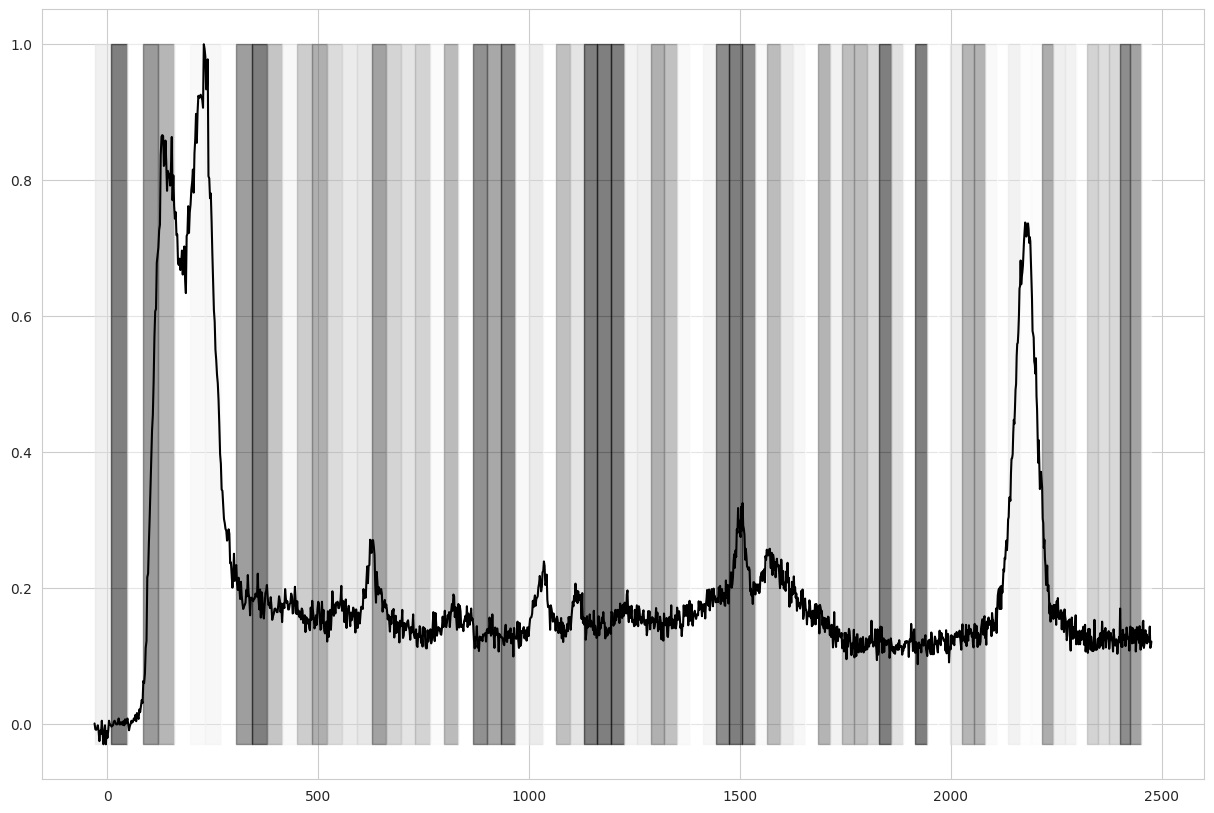

In [48]:
color_scheme = 'Greys'
# # Create a figure and axis with a wider figure size
fig = plt.figure(figsize=(15, 10))  # adjust the size as needed
# # Create the first subplot for the spectrogram
# ax1 = fig.add_subplot(2, 1, 1)
# cax = ax1.matshow(attention_weights, aspect='auto', cmap=plt.get_cmap(color_scheme), origin='upper')
# fig.colorbar(cax)
# ax1.set_xticklabels([])
# Create the second subplot for the overlapping spectra
# ax2 = fig.add_subplot(2, 1, 2)
plt.plot(f_sup_plot, data_test[spectra_index], color='black')
# Color each 100-point segment according to attention weights
cmap = plt.get_cmap(color_scheme)  # Get the colormap
SEGMENT_SIZE = input_shape[-1]  # Adjust the segment size as needed

def compute_color(segment_weights):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    color = cmap(norm(segment_weights.max()))
    color = plt.cm.Greys(segment_weights.max())
    hex_color = mcolors.rgb2hex(color)
    return hex_color

for idx in range(input_shape[0]):
    if idx == input_shape[0] - 1:
        end_index = 1599
    else:
        end_index = (idx + 1) * SEGMENT_SIZE
    start_index = idx * SEGMENT_SIZE
    segment_weights = attention_weights_plot[idx]
    hex_color = compute_color(segment_weights)
    # print("Color:", hex_color)
    # print("Segment weights:", segment_weights)
    y_range = [np.min(data_test[spectra_index]), np.max(data_test[spectra_index])]
    plt.fill_betweenx(y=y_range, x1=f_sup_plot[start_index], x2=f_sup_plot[end_index], color=hex_color, alpha=0.5)
# # Add vertical lines every 100 points
# for i in range(1, input_shape[0]):  # Adjust the range to avoid accessing an out-of-bounds index
#     ax2.axvline(x=f_sup_plot[i*input_shape[-1]], color='red', linestyle='--')

plt.show()

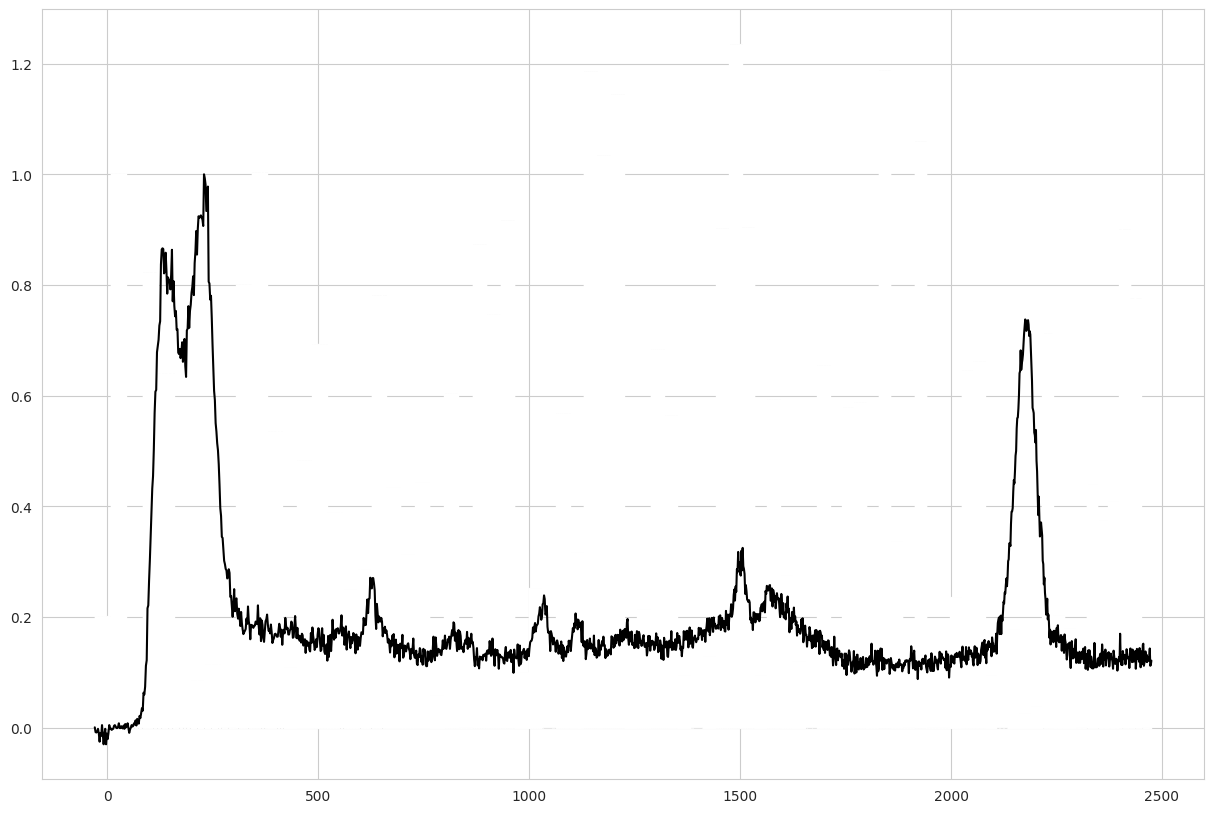

In [49]:
# Create a figure and axis with a wider figure size
fig = plt.figure(figsize=(15, 10))  # adjust the size as needed
# Create the first subplot for the spectrogram
# ax1 = fig.add_subplot(2, 1, 1)
# cax = ax1.matshow(attention_weights, aspect='auto', cmap=plt.get_cmap('Blues'), origin='upper')
# fig.colorbar(cax)
# ax1.set_xticklabels([])
# # Create the second subplot for the overlapping spectra
# ax2 = fig.add_subplot(2, 1, 2)
plt.plot(f_sup_plot, data_test[spectra_index], color='black')
# Color each 100-point segment according to attention weights
cmap = plt.get_cmap('Blues')  # Get the colormap
SEGMENT_SIZE = input_shape[-1]  # Adjust the segment size as needed

def compute_color(segment_weights):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    color = cmap(norm(segment_weights.max()))
    color = plt.cm.Greys(segment_weights.max())
    hex_color = mcolors.rgb2hex(color)
    return hex_color

for idx in range(input_shape[0]):
    if idx == input_shape[0] - 1:
        end_index = 1599
    else:
        end_index = (idx + 1) * SEGMENT_SIZE
    start_index = idx * SEGMENT_SIZE
    segment_weights = attention_weights_plot[idx]
    hex_color = compute_color(segment_weights)
    # print("Color:", hex_color)
    # print("Segment weights:", segment_weights)
    # Use bar function for visualization
    plt.bar(f_sup_plot[start_index:end_index], [segment_weights.max()] * len(f_sup_plot[start_index:end_index]), color=hex_color, width=1.0)

plt.show()

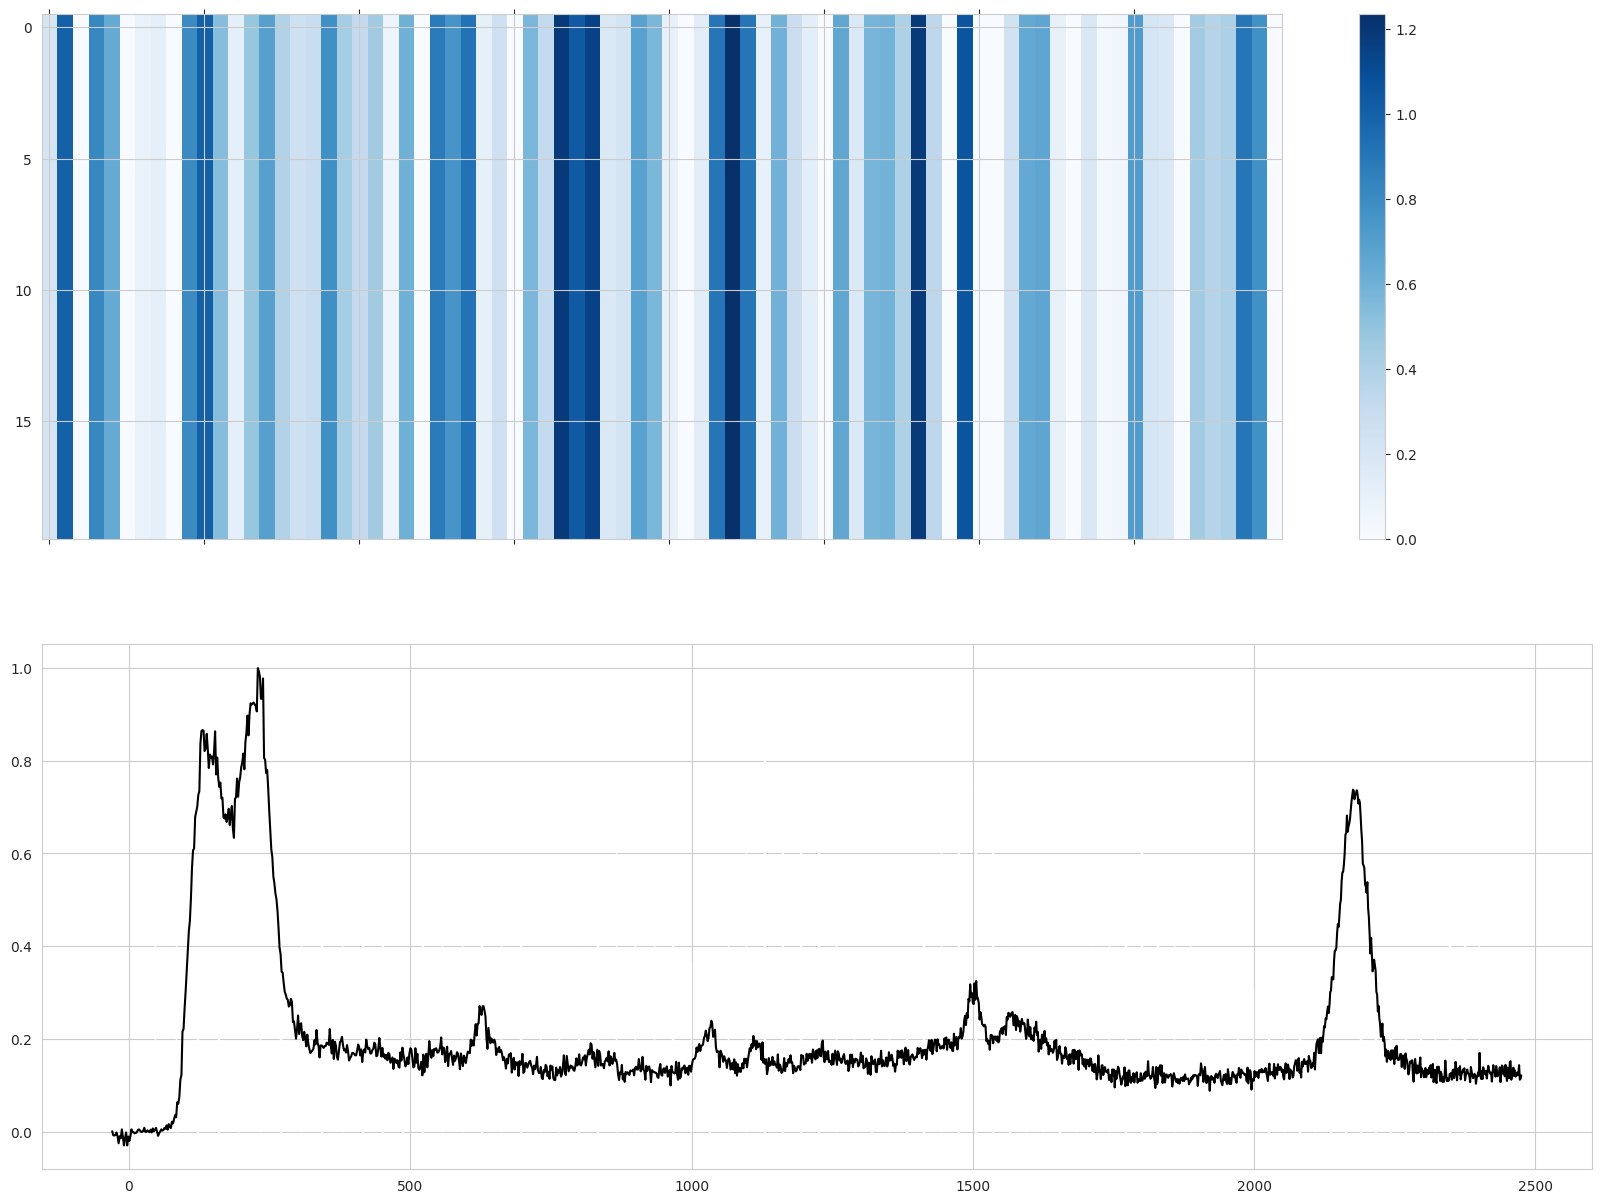

In [44]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


# Create a figure and axis with a wider figure size
fig = plt.figure(figsize=(20, 15))  # adjust the size as needed
# Create the first subplot for the spectrogram
ax1 = fig.add_subplot(2, 1, 1)
cax = ax1.matshow(attention_weights, aspect='auto', cmap=plt.get_cmap('Blues'), origin='upper')
fig.colorbar(cax)
ax1.set_xticklabels([])
# Create the second subplot for the overlapping spectra
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(f_sup_plot, data_test[spectra_index], color='black')
# Color each 100-point segment according to attention weights
cmap = plt.get_cmap('Blues')  # Get the colormap
SEGMENT_SIZE = input_shape[-1]  # Adjust the segment size as needed
window_size = 5  # The size of the sliding window applied to the moving average

weights_max = []

for idx in range(input_shape[0]):
    start_index = idx * SEGMENT_SIZE
    segment_weights = attention_weights_plot[idx]
    weights_max.append(segment_weights.max())

# Calculate moving averages
weights_avg = moving_average(np.array(weights_max), n=window_size)

for idx in range(input_shape[0] - window_size + 1):  # adjusted iteration range with window
    middle_index = (idx + window_size // 2) * SEGMENT_SIZE  # Get the middle index
    color = plt.cm.Blues(weights_avg[idx])
    hex_color = mcolors.rgb2hex(color)
    ax2.bar(f_sup_plot[middle_index], weights_avg[idx], color=hex_color, width=1.0)

plt.show()

Color: #d0e1f2
Segment weights: 0.20262343
Color: #08306b
Segment weights: 1.0030513
Color: #f7fbff
Segment weights: 0.00046809213
Color: #125ea6
Segment weights: 0.82264066
Color: #3d8dc4
Segment weights: 0.6415226
Color: #f7fbff
Segment weights: 0.00046668304
Color: #e7f0fa
Segment weights: 0.08528806
Color: #e0ecf8
Segment weights: 0.11507567
Color: #f7fbff
Segment weights: 0.0004664602
Color: #1663aa
Segment weights: 0.8025323
Color: #08306b
Segment weights: 1.004933
Color: #5fa6d1
Segment weights: 0.5354123
Color: #e1edf8
Segment weights: 0.10954541
Color: #72b2d8
Segment weights: 0.48395815
Color: #3080bd
Segment weights: 0.69249624
Color: #99c7e0
Segment weights: 0.38921383
Color: #c6dbef
Segment weights: 0.25112218
Color: #bad6eb
Segment weights: 0.28694078
Color: #1a68ae
Segment weights: 0.7812792
Color: #85bcdc
Segment weights: 0.4342091
Color: #b2d2e8
Segment weights: 0.31311148
Color: #82bbdb
Segment weights: 0.44464406
Color: #ebf3fb
Segment weights: 0.059838112
Color: #49

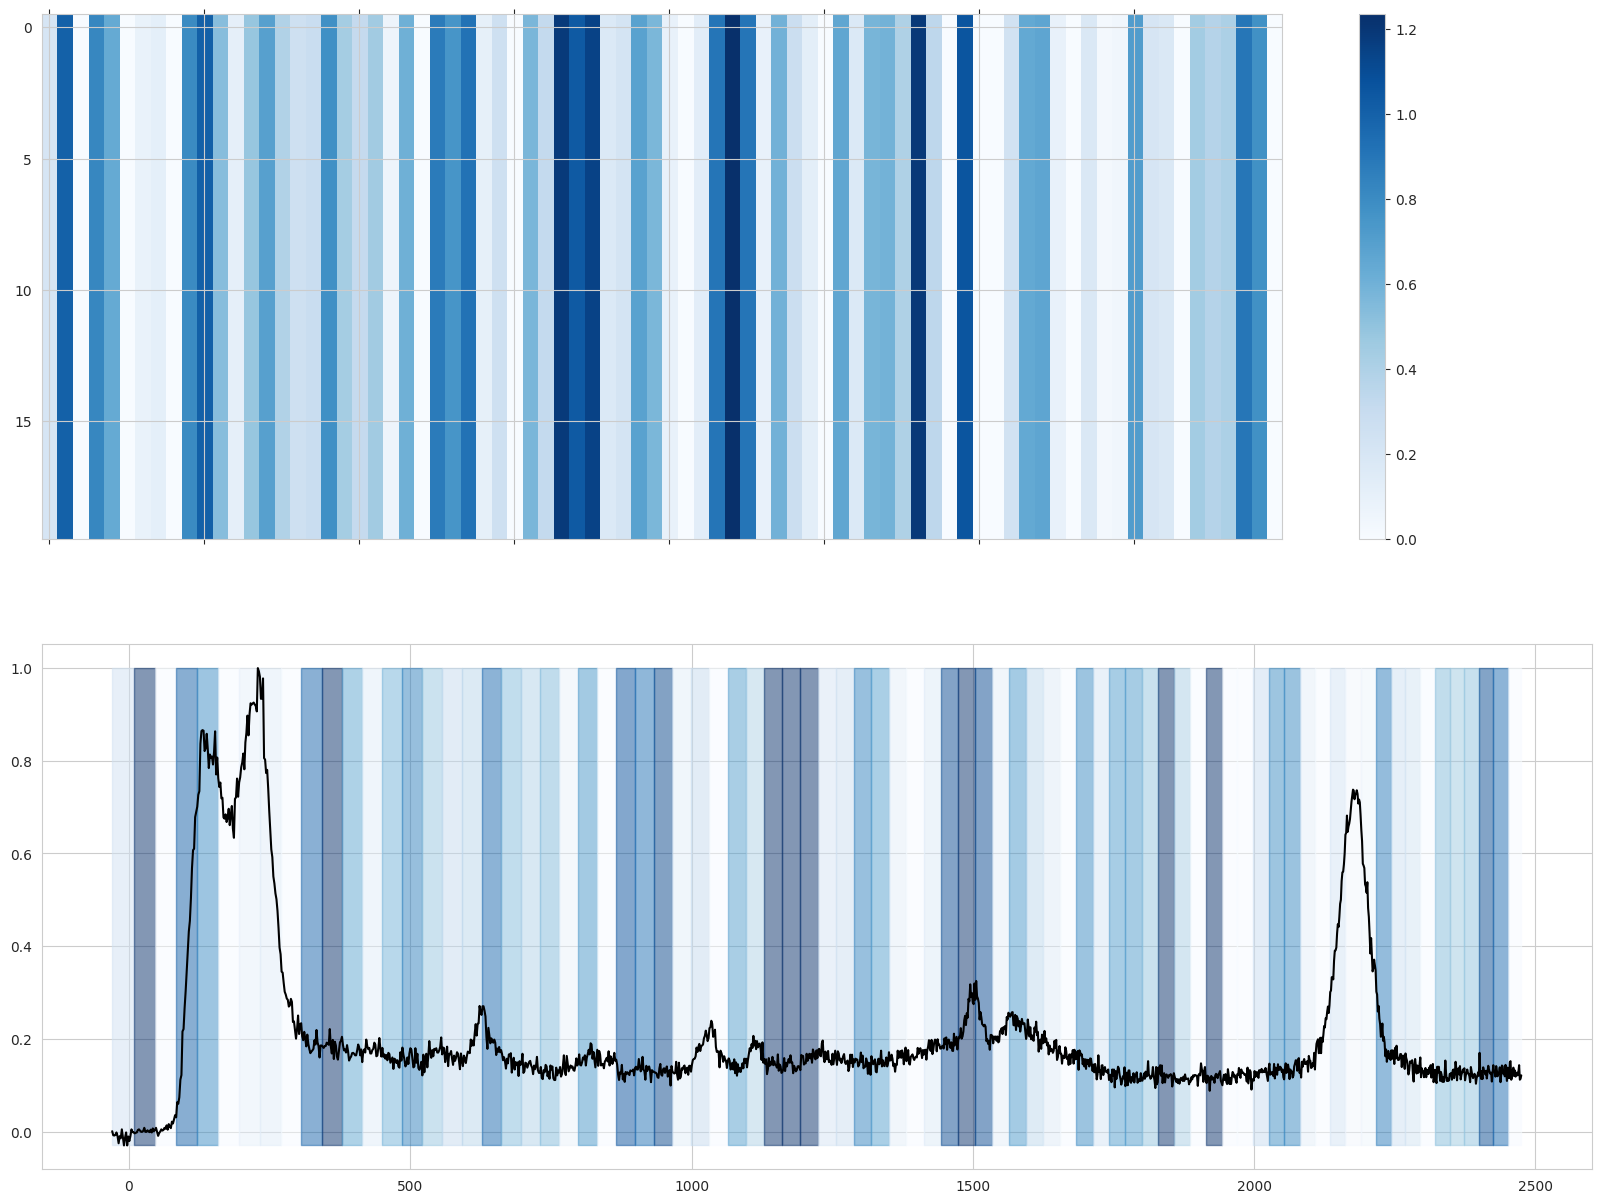

In [32]:
# # Create a figure and axis with a wider figure size
fig = plt.figure(figsize=(20, 15))  # adjust the size as needed
# # Create the first subplot for the spectrogram
ax1 = fig.add_subplot(2, 1, 1)
cax = ax1.matshow(attention_weights, aspect='auto', cmap=plt.get_cmap('Blues'), origin='upper')
fig.colorbar(cax)
ax1.set_xticklabels([])
# Create the second subplot for the overlapping spectra
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(f_sup_plot, data_test[spectra_index], color='black')
# Color each 100-point segment according to attention weights
cmap = plt.get_cmap('Blues')  # Get the colormap
SEGMENT_SIZE = input_shape[-1]  # Adjust the segment size as needed

def compute_color(segment_weights):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    color = cmap(norm(segment_weights.max()))
    color = plt.cm.Blues(segment_weights.max())
    hex_color = mcolors.rgb2hex(color)
    return hex_color

for idx in range(input_shape[0]):
    if idx == input_shape[0] - 1:
        end_index = 1599
    else:
        end_index = (idx + 1) * SEGMENT_SIZE
    start_index = idx * SEGMENT_SIZE
    segment_weights = attention_weights_plot[idx]
    hex_color = compute_color(segment_weights)
    print("Color:", hex_color)
    print("Segment weights:", segment_weights)
    y_range = [np.min(data_test[spectra_index]), np.max(data_test[spectra_index])]
    ax2.fill_betweenx(y=y_range, x1=f_sup_plot[start_index], x2=f_sup_plot[end_index], color=hex_color, alpha=0.5)
# # Add vertical lines every 100 points
# for i in range(1, input_shape[0]):  # Adjust the range to avoid accessing an out-of-bounds index
#     ax2.axvline(x=f_sup_plot[i*input_shape[-1]], color='red', linestyle='--')

plt.show()

#### Individual classes

In [33]:
input_shape = (80, 20)  # 80 chunks, each with 20 points
class ChunkAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(ChunkAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        # Adding more capacity to the attention mechanism
        self.dense1 = layers.Dense(50, activation='relu')  # Additional dense layer
        self.dense2 = layers.Dense(input_shape[1], activation='relu')  # Adjust the size accordingly
        self.attention_weights = self.add_weight(name='att_weights',
                                                 shape=(input_shape[1],),
                                                 initializer='uniform',
                                                 trainable=True)
        super(ChunkAttention, self).build(input_shape)
    def call(self, inputs):
        # A more complex attention mechanism
        x = tf.reduce_mean(inputs, axis=-1)  # Simplified example, reducing each chunk to a single value
        x = self.dense1(x)
        x = self.dense2(x)
        weighted_input = x * self.attention_weights
        return weighted_input
# Model definition
input_layer = layers.Input(shape=input_shape)
x = layers.Reshape(input_shape)(input_layer)
x = ChunkAttention()(x)
# Adding more layers and capacity to the network
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(1, activation='softmax')(x)
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 20)]          0         
                                                                 
 reshape_1 (Reshape)         (None, 80, 20)            0         
                                                                 
 chunk_attention_1 (ChunkAt  (None, 80)                8210      
 tention)                                                        
                                                                 
 dense_3 (Dense)             (None, 128)               10368     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                           

In [34]:
history_class_1 = model.fit(training_generator_class_1, epochs=10, validation_data=validation_generator_class_1)

IndexError: index 5108 is out of bounds for axis 0 with size 4500

In [ ]:
history_class_2 = model.fit(training_generator_class_2, epochs=10, validation_data=validation_generator_class_2)

In [ ]:
history_class_3 = model.fit(training_generator_class_3, epochs=10, validation_data=validation_generator_class_3)

#### 2 classes

In [90]:
input_shape = (80, 20)  # 80 chunks, each with 20 points
class ChunkAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(ChunkAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        # Adding more capacity to the attention mechanism
        self.dense1 = layers.Dense(50, activation='relu')  # Additional dense layer
        self.dense2 = layers.Dense(input_shape[1], activation='relu')  # Adjust the size accordingly
        self.attention_weights = self.add_weight(name='att_weights',
                                                 shape=(input_shape[1],),
                                                 initializer='uniform',
                                                 trainable=True)
        super(ChunkAttention, self).build(input_shape)
    def call(self, inputs):
        # A more complex attention mechanism
        x = tf.reduce_mean(inputs, axis=-1)  # Simplified example, reducing each chunk to a single value
        x = self.dense1(x)
        x = self.dense2(x)
        weighted_input = x * self.attention_weights
        return weighted_input
# Model definition
input_layer = layers.Input(shape=input_shape)
x = layers.Reshape(input_shape)(input_layer)
x = ChunkAttention()(x)
# Adding more layers and capacity to the network
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(2, activation='softmax')(x)
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 20)]          0         
                                                                 
 reshape_3 (Reshape)         (None, 80, 20)            0         
                                                                 
 chunk_attention_3 (ChunkAt  (None, 80)                8210      
 tention)                                                        
                                                                 
 dense_9 (Dense)             (None, 128)               10368     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                           

In [91]:
history_2_classes = model.fit(data_gen_2_classes, epochs=10, validation_data=data_gen_val_2_classes)

Epoch 1/10
281/281 [==============================] - 2s 3ms/step - loss: 0.1109 - accuracy: 0.9839 - val_loss: 1.0216e-04 - val_accuracy: 1.0000
Epoch 2/10
281/281 [==============================] - 1s 3ms/step - loss: 1.6798e-04 - accuracy: 1.0000 - val_loss: 2.4991e-05 - val_accuracy: 1.0000
Epoch 3/10
281/281 [==============================] - 1s 3ms/step - loss: 4.1243e-05 - accuracy: 1.0000 - val_loss: 8.0868e-04 - val_accuracy: 0.9997
Epoch 4/10
281/281 [==============================] - 1s 3ms/step - loss: 4.3993e-04 - accuracy: 0.9998 - val_loss: 1.2298e-04 - val_accuracy: 1.0000
Epoch 5/10
281/281 [==============================] - 1s 3ms/step - loss: 1.5934e-05 - accuracy: 1.0000 - val_loss: 2.6697e-05 - val_accuracy: 1.0000
Epoch 6/10
281/281 [==============================] - 1s 3ms/step - loss: 7.1819e-06 - accuracy: 1.0000 - val_loss: 6.7256e-06 - val_accuracy: 1.0000
Epoch 7/10
281/281 [==============================] - 1s 3ms/step - loss: 5.6482e-06 - accuracy: 1.0000 

In [92]:
# Check what index is in the test set where the labels are [0, 0, 1, 0, 0, 0, 0]
spectra_index = np.where(np.all(labels_test_2_classes_one_hot == [0, 1], axis=1))[0]

In [93]:
spectra_index

array([   0,    2,    4, ..., 2994, 2996, 2998])

In [94]:
label_index = 19  # Replace 0 with the desired label index
spectra_index = 19  # Replace 0 with the desired spectra index

input_shape = (80, 20) # 40 chunks, each with 40 points

data_gen_test = DataGenerator(data_test_2_classes, labels_test_2_classes_one_hot, batch_size=32, dim=input_shape, n_channels=1, n_classes=2, shuffle=False)

# Get the specific spectra and label
specific_spectra = data_test_2_classes[spectra_index]
specific_label = labels_test_2_classes_one_hot[spectra_index]

# Reshape the spectra for evaluation
specific_spectra_reshaped = specific_spectra.reshape(1, input_shape[0], input_shape[-1], 1)
specific_label = specific_label.reshape(1, 2)

# Evaluate the model for the specific spectra
loss, accuracy = model.evaluate(specific_spectra_reshaped, specific_label)

print(f"Loss for Label {label_index} and Spectra {spectra_index}: {loss}")
print(f"Accuracy for Label {label_index} and Spectra {spectra_index}: {accuracy}")


1/1 [==============================] - 0s 109ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Loss for Label 19 and Spectra 19: 0.0
Accuracy for Label 19 and Spectra 19: 1.0


In [103]:
attention_layer = model.get_layer('chunk_attention_3')  # replace 'chunk_attention' with the name of your ChunkAttention layer if it's different
attention_weights = attention_layer.get_weights()[0]

print(attention_weights)

[ 1.27289332e-02  3.53119173e-03 -4.07931432e-02  4.04225476e-02
 -1.22574419e-01  1.49560403e-02  1.24086097e-01 -4.31144983e-02
  5.39485700e-05  4.05642539e-02 -7.70491213e-02 -7.10333586e-02
 -2.13686470e-02  1.25914082e-01 -4.33701947e-02  8.68594795e-02
 -1.69650428e-02 -1.04476824e-01 -8.62084702e-03  1.39160790e-02
 -6.73567727e-02  5.25398785e-03  1.41954809e-01 -4.67920825e-02
  1.09950915e-01 -7.93376118e-02  2.00706385e-02  1.02479838e-01
  1.11929186e-01  9.70527679e-02  1.90799721e-02  7.19430333e-04
  6.07663058e-02  3.89131866e-02 -1.37507185e-01  1.19152673e-01
 -1.34466775e-02 -1.17990822e-01 -4.81519476e-02 -1.06179491e-01
 -6.26467541e-03 -1.20076418e-01  1.08966967e-02 -8.14254582e-02
 -1.14254579e-01 -8.30446258e-02 -2.52211764e-02  1.65561900e-01
 -2.67676711e-02  7.52354600e-03  1.08121216e-01  1.37596145e-01
  4.17167060e-02 -2.47396957e-02 -4.47480455e-02  1.03891790e-01
  1.18743993e-01 -5.56647778e-03  2.02420771e-01 -5.91346622e-02
 -1.20874614e-01  1.29233

In [104]:
f_sup, _ = rd.read_data("../data/20220422 SERS data generation/analyte 1/mapping50X50/1_3min_b3_50X50_spectral_mapping_1.tif")

In [105]:
f_sup_plot = np.copy(f_sup)
attention_weights_plot = np.copy(attention_weights)

# Reshape attention_weights to match the number of chunks in f_sup
attention_weights = np.repeat(attention_weights, input_shape[-1])  # repeat each weight 100 times to match the 1600 points

# Reshape f_sup and attention_weights to a 2D array for the spectrogram
f_sup = f_sup.reshape(input_shape)  # swap the dimensions to match the desired shape
attention_weights = attention_weights.reshape(input_shape)  # swap the dimensions to match the desired shape

# Transpose f_sup and attention_weights
f_sup = f_sup.T
attention_weights = attention_weights.T

In [106]:
data_test_2_classes.shape

(3000, 1600)

In [107]:
f_sup_plot.shape

(1600,)

Color: #3e51c5
Segment weights: 0.012728933
Color: #3b4cc0
Segment weights: 0.0035311917
Color: #3b4cc0
Segment weights: -0.040793143
Color: #465ecf
Segment weights: 0.040422548
Color: #3b4cc0
Segment weights: -0.12257442
Color: #3e51c5
Segment weights: 0.01495604
Color: #6180e9
Segment weights: 0.1240861
Color: #3b4cc0
Segment weights: -0.0431145
Color: #3b4cc0
Segment weights: 5.394857e-05
Color: #465ecf
Segment weights: 0.040564254
Color: #3b4cc0
Segment weights: -0.07704912
Color: #3b4cc0
Segment weights: -0.07103336
Color: #3b4cc0
Segment weights: -0.021368647
Color: #6282ea
Segment weights: 0.12591408
Color: #3b4cc0
Segment weights: -0.043370195
Color: #5572df
Segment weights: 0.08685948
Color: #3b4cc0
Segment weights: -0.016965043
Color: #3b4cc0
Segment weights: -0.104476824
Color: #3b4cc0
Segment weights: -0.008620847
Color: #3e51c5
Segment weights: 0.013916079
Color: #3b4cc0
Segment weights: -0.06735677
Color: #3c4ec2
Segment weights: 0.005253988
Color: #6788ee
Segment weights

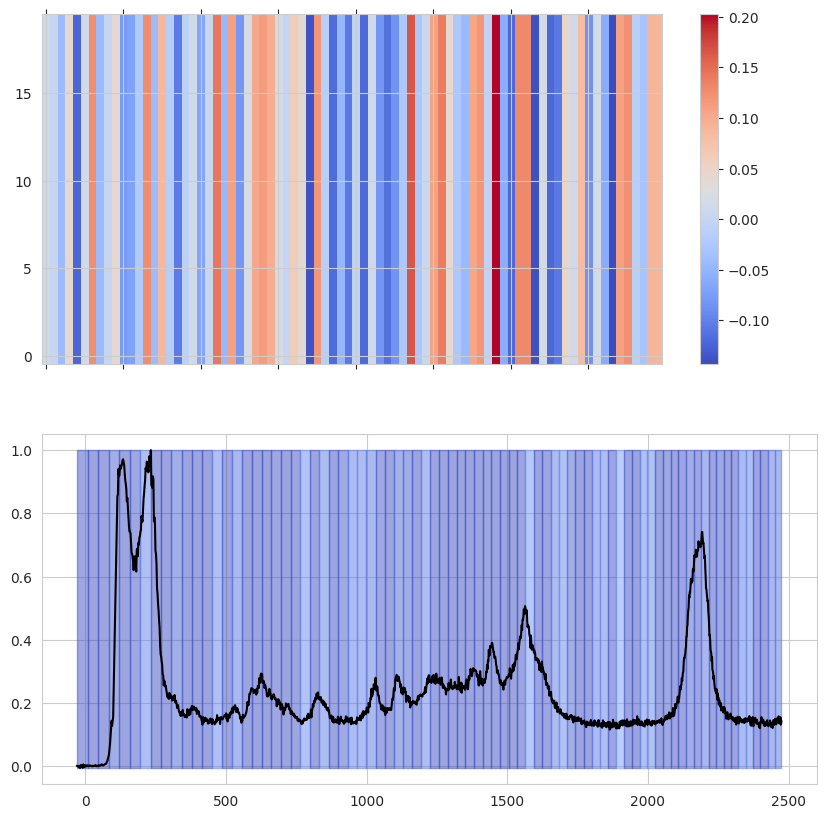

In [109]:
# # Create a figure and axis with a wider figure size
fig = plt.figure(figsize=(10, 10))  # adjust the size as needed

# # Create the first subplot for the spectrogram
ax1 = fig.add_subplot(2, 1, 1)
cax = ax1.matshow(attention_weights, aspect='auto', cmap=plt.get_cmap('coolwarm'), origin='lower')
fig.colorbar(cax)
ax1.set_xticklabels([])

# Create the second subplot for the overlapping spectra
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(f_sup_plot, data_test_2_classes[spectra_index], color='black')

# Color each 100-point segment according to attention weights
cmap = plt.get_cmap('coolwarm')  # Get the colormap
SEGMENT_SIZE = input_shape[-1]  # Adjust the segment size as needed


def compute_color(segment_weights):
    norm = mcolors.Normalize(vmin=0, vmax=1)
    color = cmap(norm(segment_weights.max()))
    color = plt.cm.coolwarm(segment_weights.max())
    hex_color = mcolors.rgb2hex(color)
    return hex_color


for idx in range(input_shape[0]):
    if idx == input_shape[0] - 1:
        end_index = 1599
    else:
        end_index = (idx + 1) * SEGMENT_SIZE
    start_index = idx * SEGMENT_SIZE
    segment_weights = attention_weights_plot[idx]

    hex_color = compute_color(segment_weights)

    print("Color:", hex_color)
    print("Segment weights:", segment_weights)

    y_range = [np.min(data_test[spectra_index]), np.max(data_test[spectra_index])]
    ax2.fill_betweenx(y=y_range, x1=f_sup_plot[start_index], x2=f_sup_plot[end_index], color=hex_color, alpha=0.5)

# # Add vertical lines every 100 points
# for i in range(1, input_shape[0]):  # Adjust the range to avoid accessing an out-of-bounds index
#     ax2.axvline(x=f_sup_plot[i*input_shape[-1]], color='red', linestyle='--')

plt.show()

#### 3 classes

In [ ]:
input_shape = (80, 20)  # 80 chunks, each with 20 points
class ChunkAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(ChunkAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        # Adding more capacity to the attention mechanism
        self.dense1 = layers.Dense(50, activation='relu')  # Additional dense layer
        self.dense2 = layers.Dense(input_shape[1], activation='relu')  # Adjust the size accordingly
        self.attention_weights = self.add_weight(name='att_weights',
                                                 shape=(input_shape[1],),
                                                 initializer='uniform',
                                                 trainable=True)
        super(ChunkAttention, self).build(input_shape)
    def call(self, inputs):
        # A more complex attention mechanism
        x = tf.reduce_mean(inputs, axis=-1)  # Simplified example, reducing each chunk to a single value
        x = self.dense1(x)
        x = self.dense2(x)
        weighted_input = x * self.attention_weights
        return weighted_input
# Model definition
input_layer = layers.Input(shape=input_shape)
x = layers.Reshape(input_shape)(input_layer)
x = ChunkAttention()(x)
# Adding more layers and capacity to the network
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(3, activation='softmax')(x)
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history_3_classes = model.fit(data_gen_3_classes, epochs=10, validation_data=data_gen_val_3_classes)

#### 4 classes

In [ ]:
input_shape = (80, 20)  # 80 chunks, each with 20 points
class ChunkAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(ChunkAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        # Adding more capacity to the attention mechanism
        self.dense1 = layers.Dense(50, activation='relu')  # Additional dense layer
        self.dense2 = layers.Dense(input_shape[1], activation='relu')  # Adjust the size accordingly
        self.attention_weights = self.add_weight(name='att_weights',
                                                 shape=(input_shape[1],),
                                                 initializer='uniform',
                                                 trainable=True)
        super(ChunkAttention, self).build(input_shape)
    def call(self, inputs):
        # A more complex attention mechanism
        x = tf.reduce_mean(inputs, axis=-1)  # Simplified example, reducing each chunk to a single value
        x = self.dense1(x)
        x = self.dense2(x)
        weighted_input = x * self.attention_weights
        return weighted_input
# Model definition
input_layer = layers.Input(shape=input_shape)
x = layers.Reshape(input_shape)(input_layer)
x = ChunkAttention()(x)
# Adding more layers and capacity to the network
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(4, activation='softmax')(x)
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history_4_classes = model.fit(data_gen_4_classes, epochs=10, validation_data=data_gen_val_4_classes)

#### 5 classes

In [ ]:
input_shape = (80, 20)  # 80 chunks, each with 20 points
class ChunkAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(ChunkAttention, self).__init__(**kwargs)
    def build(self, input_shape):
        # Adding more capacity to the attention mechanism
        self.dense1 = layers.Dense(50, activation='relu')  # Additional dense layer
        self.dense2 = layers.Dense(input_shape[1], activation='relu')  # Adjust the size accordingly
        self.attention_weights = self.add_weight(name='att_weights',
                                                 shape=(input_shape[1],),
                                                 initializer='uniform',
                                                 trainable=True)
        super(ChunkAttention, self).build(input_shape)
    def call(self, inputs):
        # A more complex attention mechanism
        x = tf.reduce_mean(inputs, axis=-1)  # Simplified example, reducing each chunk to a single value
        x = self.dense1(x)
        x = self.dense2(x)
        weighted_input = x * self.attention_weights
        return weighted_input
# Model definition
input_layer = layers.Input(shape=input_shape)
x = layers.Reshape(input_shape)(input_layer)
x = ChunkAttention()(x)
# Adding more layers and capacity to the network
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
x = layers.Dense(5, activation='softmax')(x)
model = models.Model(inputs=input_layer, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
history_5_classes = model.fit(data_gen_5_classes, epochs=10, validation_data=data_gen_val_5_classes)